In [7]:
import os
from pathlib import Path

import pandas as pd
from matplotlib import pyplot as plt

# Get list of all CSV files in the directory
list_of_commits = list(Path("../../logs/performance/analysis").glob("*/"))
list_of_commits.sort(key=os.path.getmtime, reverse=True)
list_of_commits = list_of_commits[:1]
# Initialize an empty DataFrame to store combined results
df_latest = pd.DataFrame()

list_of_files = list(Path(list_of_commits[0] / "all").glob("*.csv"))
# For each file in this commit
for file_path in list_of_files:
    # Read the CSV file
    temp_df = pd.read_csv(file_path)

    # Append to the main DataFrame
    df_latest = pd.concat([df_latest, temp_df], ignore_index=True)

# format: "timestamp", "category", "test_name", "query", "scenario",
#          "execution_time", "results_consistent", "fainder_mode",
#          "num_results", "ids", "num_terms", "id_str", "write_groups_used",
#          "write_groups_actually_used", "fainder_parallel", "fainder_max_workers",
#          "fainder_contiguous_chunks", "optimizer_cost_sorting",
#          "optimizer_keyword_merging", "optimizer_split_up_junctions"
print(df_latest)

# First check the unique category values to see what we're working with
print("Unique categories:", df_latest["category"].unique())

# Strip whitespace and normalize the category column
df_latest["category"] = df_latest["category"].str.strip()


os.makedirs("figures/analysis", exist_ok=True)

                timestamp              category  \
0     2025-06-02 22:17:19  base_keyword_queries   
1     2025-06-02 22:17:19  base_keyword_queries   
2     2025-06-02 22:17:19  base_keyword_queries   
3     2025-06-02 22:17:19  base_keyword_queries   
4     2025-06-02 22:17:20  base_keyword_queries   
...                   ...                   ...   
3963  2025-06-02 20:05:27      NOT_Combinations   
3964  2025-06-02 20:05:55      NOT_Combinations   
3965  2025-06-02 20:05:55      NOT_Combinations   
3966  2025-06-02 20:05:55      NOT_Combinations   
3967  2025-06-02 20:05:55      NOT_Combinations   

                            test_name  \
0                    simple_keyword_1   
1                    simple_keyword_1   
2                    simple_keyword_1   
3                    simple_keyword_1   
4                    simple_keyword_1   
...                               ...   
3963  mixed_combination_AND_1_0-1-2-3   
3964  mixed_combination_AND_1_0-1-2-3   
3965  mixed_combin

In [8]:
# Filter the DataFrame by category with stripped values
base_keyword_queries = df_latest[
    df_latest["category"] == "base_keyword_queries"
].reset_index(drop=True)
base_keyword_queries_with_multiple_elements = df_latest[
    df_latest["category"] == "base_keyword_queries_with_multiple_elements"
].reset_index(drop=True)
base_percentile_queries = df_latest[
    df_latest["category"] == "base_percentile_queries"
].reset_index(drop=True)
base_column_name_queries = df_latest[
    df_latest["category"] == "base_column_name_queries"
].reset_index(drop=True)
percentile_combinations = df_latest[
    df_latest["category"] == "percentile_combinations"
].reset_index(drop=True)
mixed_combinations_with_fixed_structure = df_latest[
    df_latest["category"] == "mixed_combinations_with_fixed_structure"
].reset_index(drop=True)
mixed_combinations_with_fixed_structure_extented = df_latest[
    df_latest["category"] == "mixed_combinations_with_fixed_structure_extented"
].reset_index(drop=True)
early_exit = df_latest[df_latest["category"] == "early_exit"].reset_index(drop=True)
# Filter for multiple percentile combinations
multiple_percentile_combinations = df_latest[
    df_latest["category"] == "multiple_percentile_combinations"
].reset_index(drop=True)
multiple_percentile_combinations_with_kw = df_latest[
    df_latest["category"] == "multiple_percentile_combinations_with_kw"
].reset_index(drop=True)
expected_form_not_queries = df_latest[
    df_latest["category"] == "expected_form_not_queries"
].reset_index(drop=True)
double_expected_form_queries = df_latest[
    df_latest["category"] == "double_expected_form_queries"
].reset_index(drop=True)
middle_exit = df_latest[df_latest["category"] == "middle_exit"].reset_index(drop=True)


# Print to verify the filtering worked
print("\nCounts after fixing whitespace:")
print("Base keyword queries:", len(base_keyword_queries))
print(
    "Base keyword queries with multiple elements:",
    len(base_keyword_queries_with_multiple_elements),
)
print("Base percentile queries:", len(base_percentile_queries))
print("Percentile combinations:", len(percentile_combinations))
print(
    "Mixed combinations with fixed structure:",
    len(mixed_combinations_with_fixed_structure),
)
print(
    "Mixed combinations with fixed structure extended:",
    len(mixed_combinations_with_fixed_structure_extented),
)
print("Early exit:", len(early_exit))
print("Multiple percentile combinations:", len(multiple_percentile_combinations))
print(
    "Multiple percentile combinations with keyword:",
    len(multiple_percentile_combinations_with_kw),
)
print("Expected form not queries:", len(expected_form_not_queries))
print("Double expected form queries:", len(double_expected_form_queries))
print("Middle exit:", len(middle_exit))
# Prepare data for plotting
# Get unique scenarios and colors for plotting
scenarios = base_keyword_queries["scenario"].unique()
colors = ["r", "g", "b", "y", "c", "m", "k"]


Counts after fixing whitespace:
Base keyword queries: 320
Base keyword queries with multiple elements: 320
Base percentile queries: 160
Percentile combinations: 0
Mixed combinations with fixed structure: 0
Mixed combinations with fixed structure extended: 0
Early exit: 0
Multiple percentile combinations: 0
Multiple percentile combinations with keyword: 0
Expected form not queries: 0
Double expected form queries: 0
Middle exit: 0


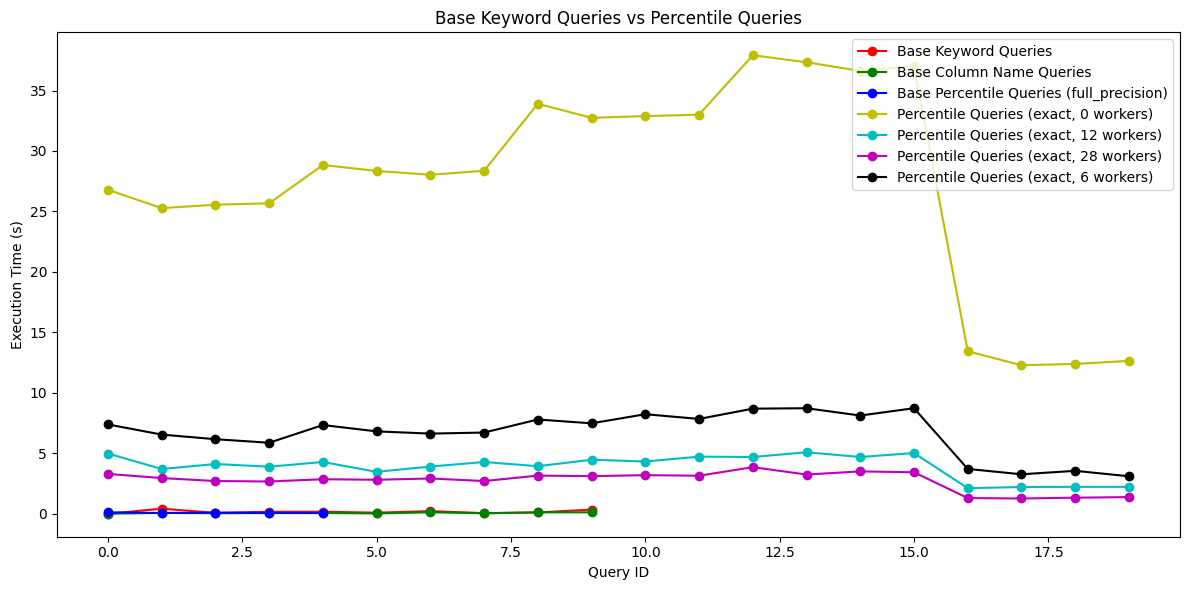

In [9]:
# a plot with three lines (one base_keyword_queries and two percentile queries (different fainder modes) per num_workers) x-axis is queryid
plt.figure(figsize=(12, 6))
plt.title("Base Keyword Queries vs Percentile Queries")
plt.xlabel("Query ID")
plt.ylabel("Execution Time (s)")
fainder_modes = base_keyword_queries["fainder_mode"].unique()

# Plot base keyword queries
base_keyword_queries = (
    base_keyword_queries.groupby("query")["execution_time"].mean().reset_index()
)
plt.plot(
    base_keyword_queries.index,
    base_keyword_queries["execution_time"],
    label="Base Keyword Queries",
    color=colors[0],
    marker="o",
)
# Plot column name queries
base_column_name_queries = (
    base_column_name_queries.groupby("query")["execution_time"].mean().reset_index()
)
plt.plot(
    base_column_name_queries.index,
    base_column_name_queries["execution_time"],
    label="Base Column Name Queries",
    color=colors[1],
    marker="o",
)
i = 2
# Plot base percentile queries not exact mode
fainder_modes_without_exact = [mode for mode in fainder_modes if mode != "exact"]

for fainder_mode in fainder_modes_without_exact:
    mode_queries = base_percentile_queries[
        base_percentile_queries["fainder_mode"] == fainder_mode
    ].reset_index(drop=True)
    mode_queries = mode_queries.groupby("query")["execution_time"].mean().reset_index()
    plt.plot(
        mode_queries.index,
        mode_queries["execution_time"],
        label=f"Base Percentile Queries ({fainder_mode})",
        color=colors[i % len(colors)],
        marker="o",
    )
    i += 1

# Plot base percentile queries [exact]
num_workers = base_percentile_queries["fainder_max_workers"].unique()

fainder_mode_exact = "exact"
for num_worker in num_workers:
    percentile_queries = base_percentile_queries[
        base_percentile_queries["fainder_max_workers"] == num_worker
    ].reset_index(drop=True)
    mode_queries = percentile_queries[
        percentile_queries["fainder_mode"] == fainder_mode_exact
    ].reset_index(drop=True)
    plt.plot(
        mode_queries.index,
        mode_queries["execution_time"],
        label=f"Percentile Queries ({fainder_mode_exact}, {num_worker} workers)",
        color=colors[i % len(colors)],
        marker="o",
    )
    i += 1
plt.xticks()
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig("figures/analysis/base_predicates.png")

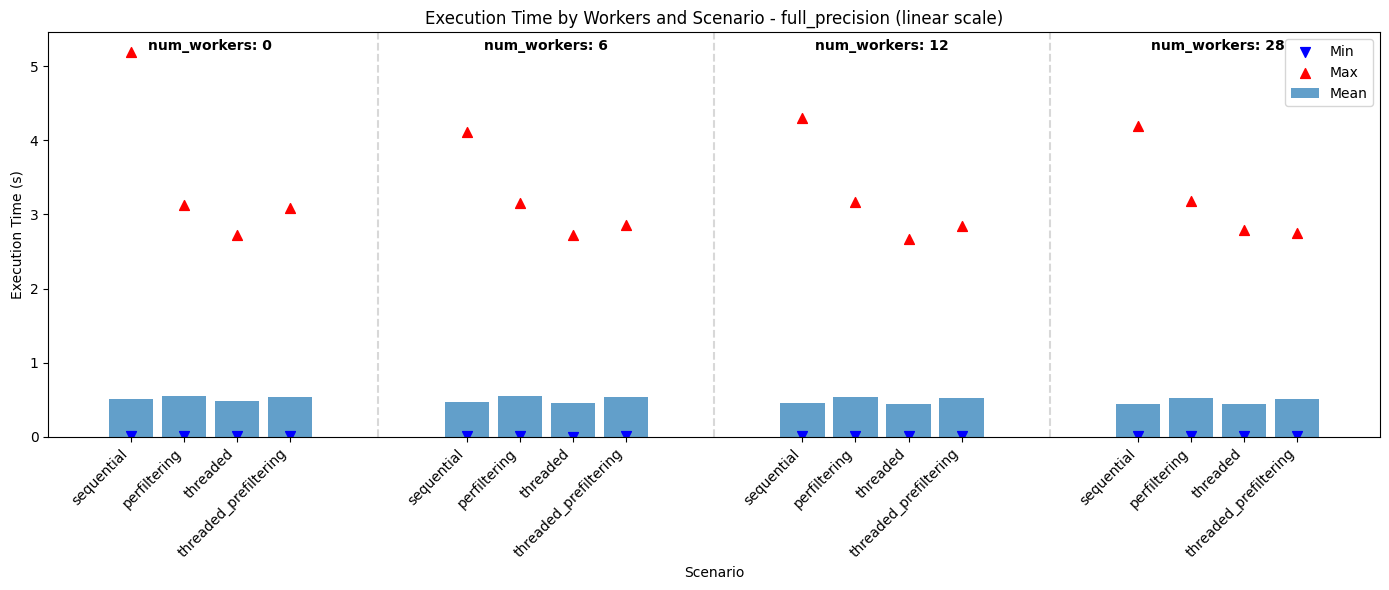

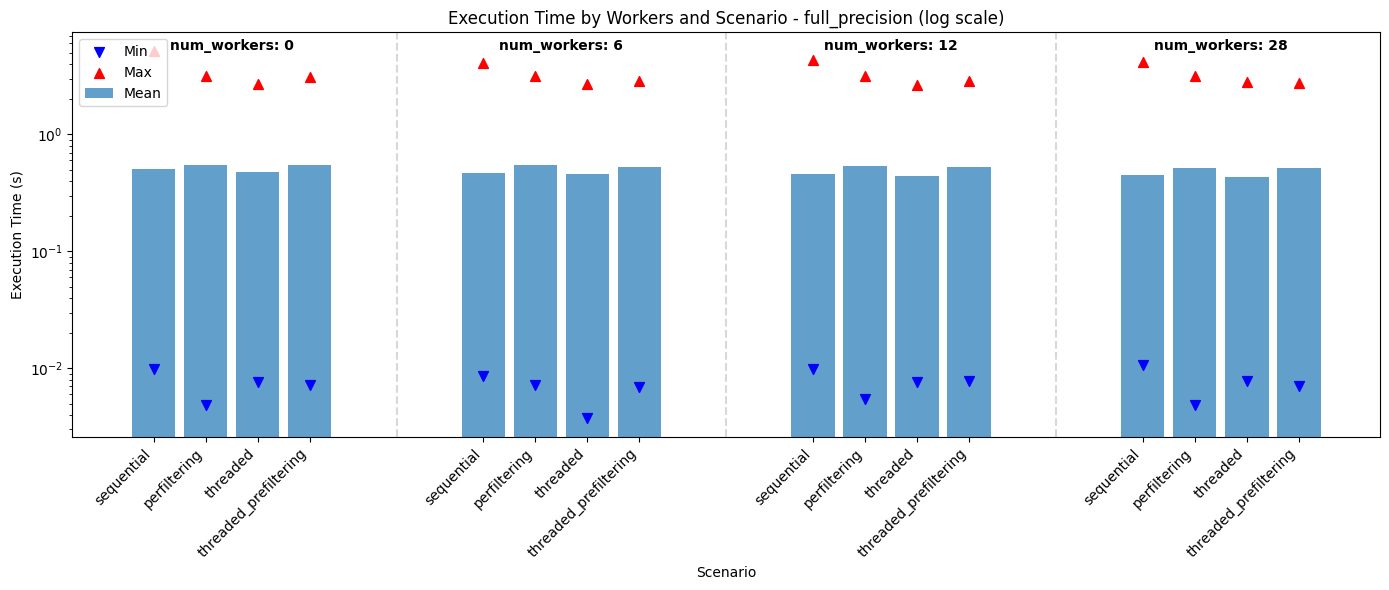

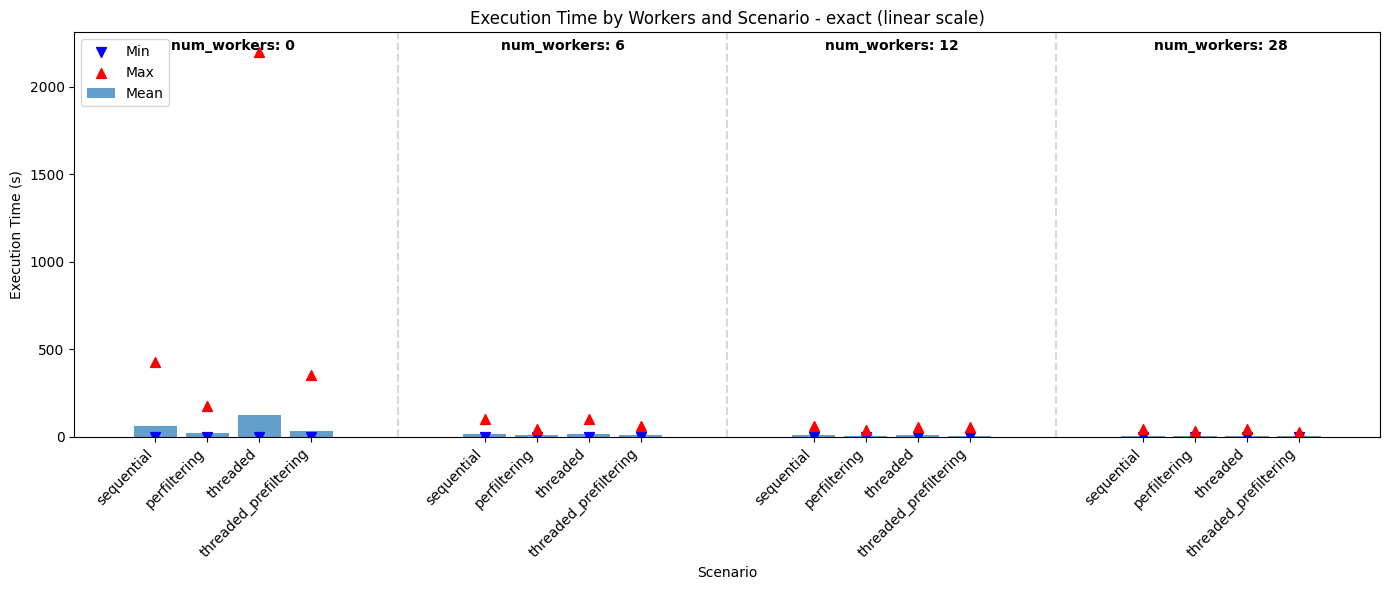

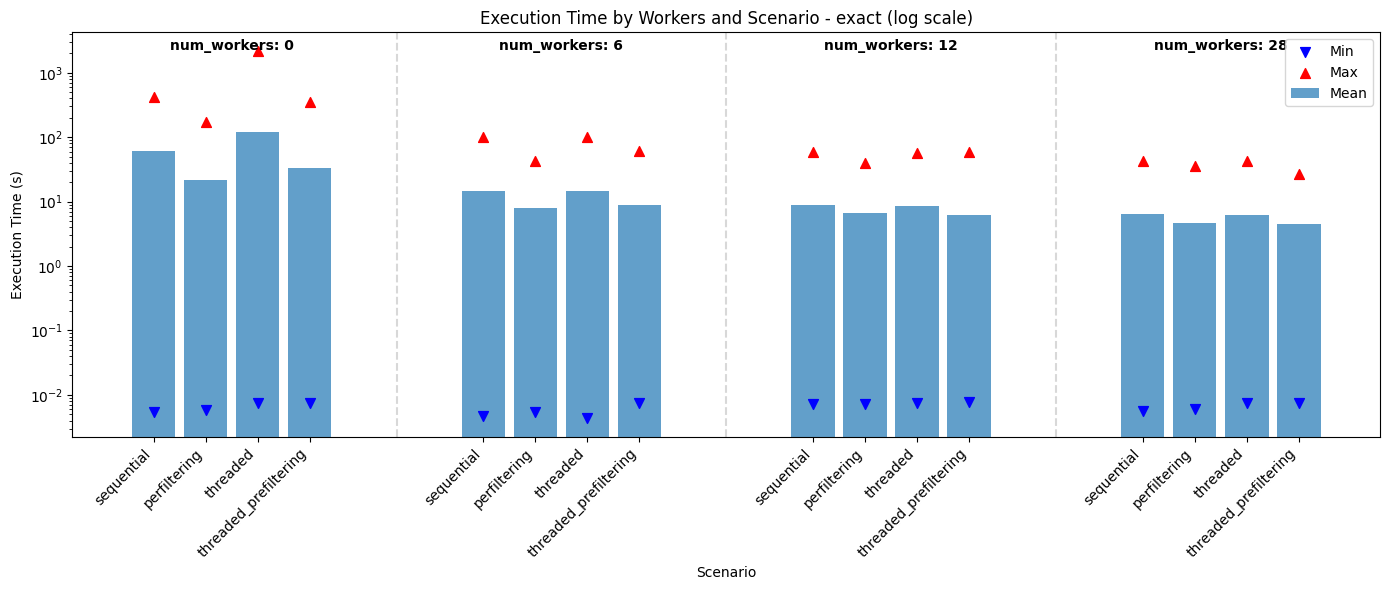

In [10]:
# Compare execution time (y-axis min, max, mean) against scenario and num_workers (x-axis) for one plot per fainder mode

import numpy as np


for fainder_mode in df_latest["fainder_mode"].unique():
    df_fainder_mode = df_latest[df_latest["fainder_mode"] == fainder_mode]
    
    # Create two figures - one with linear scale, one with log scale
    for scale_type in ["linear", "log"]:
        plt.figure(figsize=(14, 6))
        plt.title(f"Execution Time by Workers and Scenario - {fainder_mode} ({scale_type} scale)")
        plt.xlabel("Scenario")
        plt.ylabel("Execution Time (s)")
        
        if scale_type == "log":
            plt.yscale('log')

        # Group first by workers then by scenario
        grouped_data = df_fainder_mode.groupby(["fainder_max_workers", "scenario"])

        # Get unique workers and scenarios
        unique_workers = sorted(df_fainder_mode["fainder_max_workers"].unique())
        unique_scenarios = df_fainder_mode["scenario"].unique()

        # Set up positions for bar groups with smaller separation between same workers
        groups = list(grouped_data.groups.keys())

        # Create a dictionary to map (worker, scenario) to x position
        x_pos_map = {}
        current_x = 0

        for worker in unique_workers:
            # Create positions for this worker's scenarios with small gaps between them
            scenario_positions = [current_x + i * 0.3 for i in range(len(unique_scenarios))]
            for i, scenario in enumerate(unique_scenarios):
                x_pos_map[(worker, scenario)] = scenario_positions[i]

            # Add larger gap between different worker groups
            current_x = scenario_positions[-1] + 1

        # Get x positions for each group
        x_positions = [x_pos_map[(worker, scenario)] for worker, scenario in groups]

        # Prepare labels
        labels = [f"{workers} - {scenario}" for workers, scenario in groups]

        # Collect data for plotting
        min_times = []
        max_times = []
        mean_times = []

        for (workers, scenario), group in grouped_data:
            execution_times = group["execution_time"]

            # Calculate statistics
            min_times.append(execution_times.min())
            max_times.append(execution_times.max())
            mean_times.append(execution_times.mean())

        # Create bars for mean values
        plt.bar(x_positions, mean_times, width=0.25, alpha=0.7, label="Mean")

        # Add markers for min and max
        plt.scatter(x_positions, min_times, marker="v", color="blue", s=50, label="Min")
        plt.scatter(x_positions, max_times, marker="^", color="red", s=50, label="Max")

        # Add vertical lines to separate worker groups
        current_line_x = -0.5
        for worker in unique_workers[:-1]:  # Don't add line after last worker
            current_line_x = x_pos_map[(worker, unique_scenarios[-1])] + 0.5
            plt.axvline(x=current_line_x, color="gray", linestyle="--", alpha=0.3)

        # Add worker labels centered for each group
        for worker in unique_workers:
            first_x = x_pos_map[(worker, unique_scenarios[0])]
            last_x = x_pos_map[(worker, unique_scenarios[-1])]
            
            # worker underneath the top of the y-axis
            if scale_type == "log":
                y_bottom, y_top = plt.ylim()
                y_pos = np.exp(np.log(y_top) - (np.log(y_top) - np.log(y_bottom)) * 0.05)  
            else:
                y_pos = plt.ylim()[1] * 0.95
            
            plt.text(
                (first_x + last_x) / 2,
                y_pos,
                f"num_workers: {worker}",
                ha="center",
                va="bottom",
                fontsize=10,
                fontweight="bold",
            )

        # Set the x-tick labels to scenario names (not workers)
        plt.xticks(
            x_positions, [scenario for _, scenario in groups], rotation=45, ha="right"
        )

        plt.legend()
        plt.tight_layout()
        if scale_type == "linear":
            plt.savefig(f"figures/analysis/all_categories_{fainder_mode}_by_workers.png")
        else:
            plt.savefig(f"figures/analysis/all_categories_{fainder_mode}_by_workers_{scale_type}.png")

/tmp/ipykernel_57181/1356520180.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(14, 6))


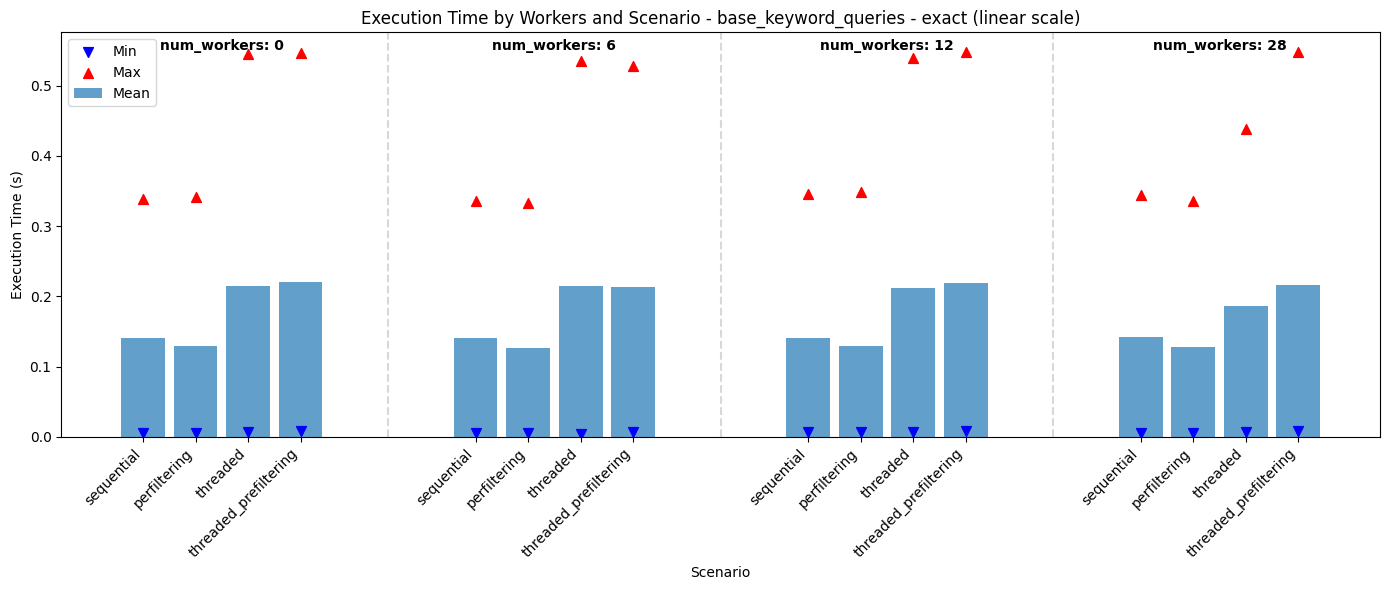

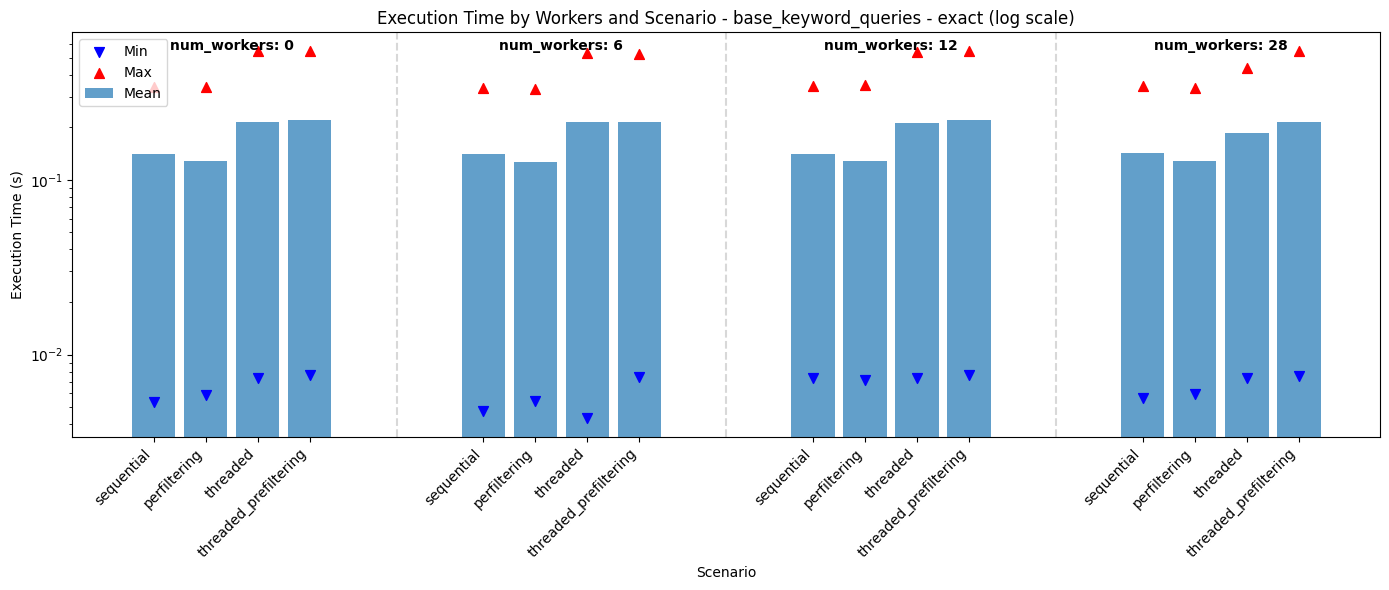

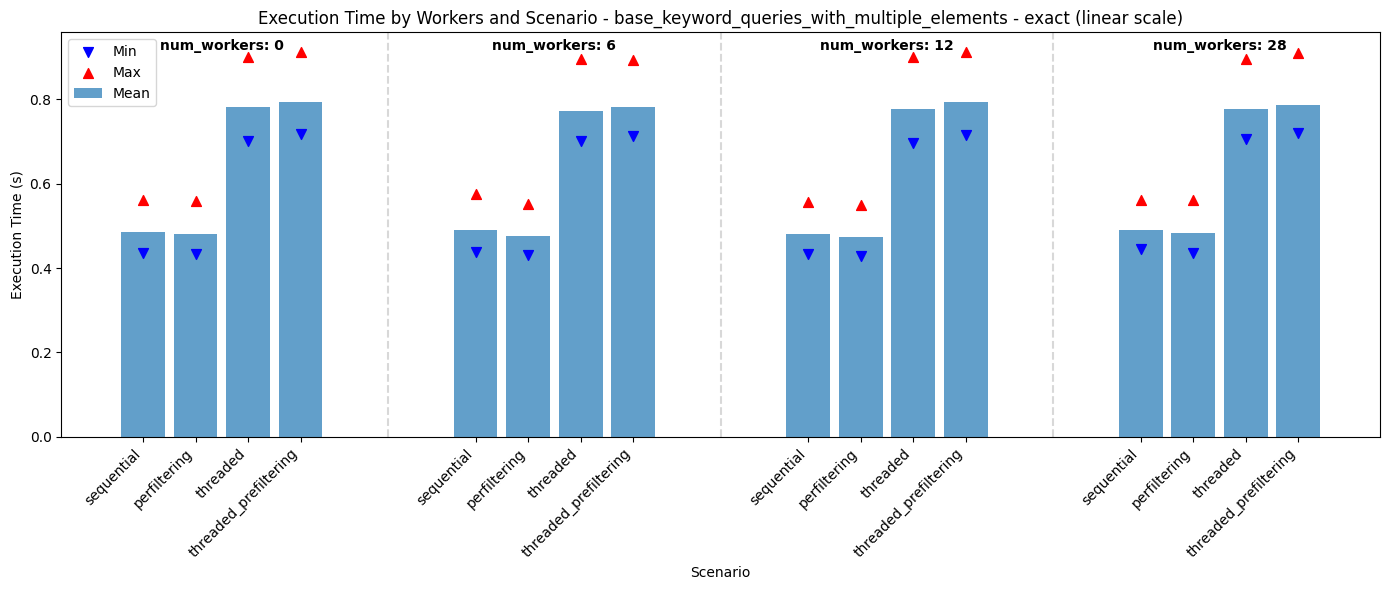

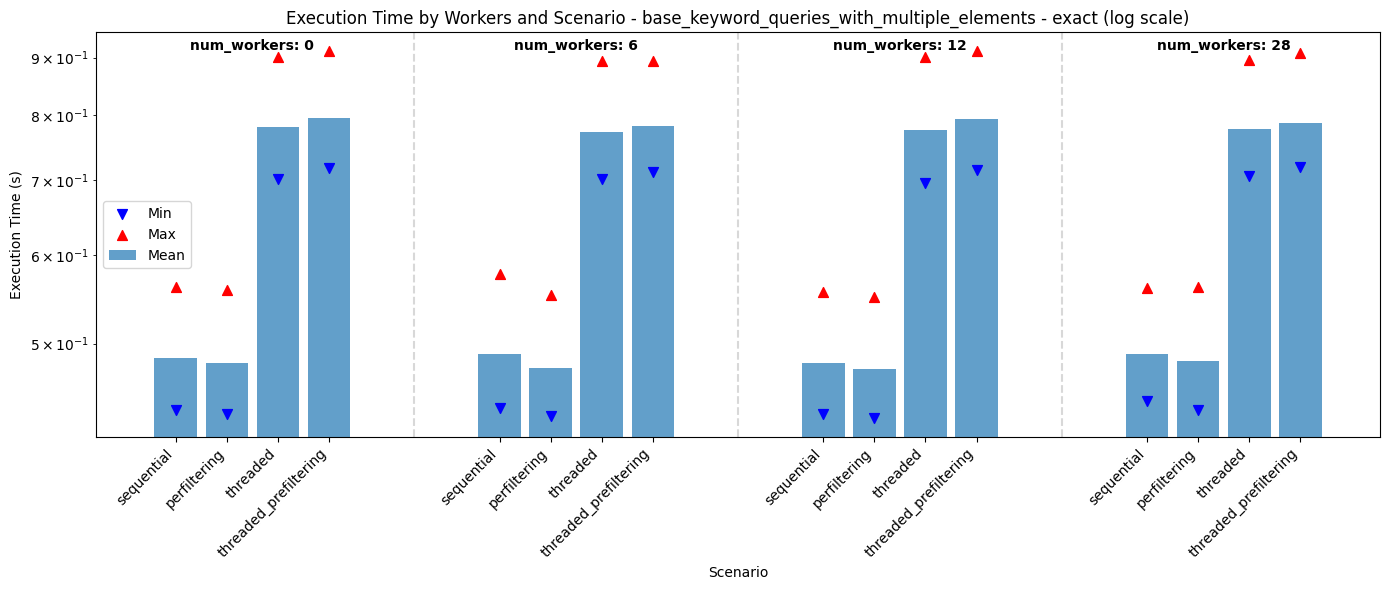

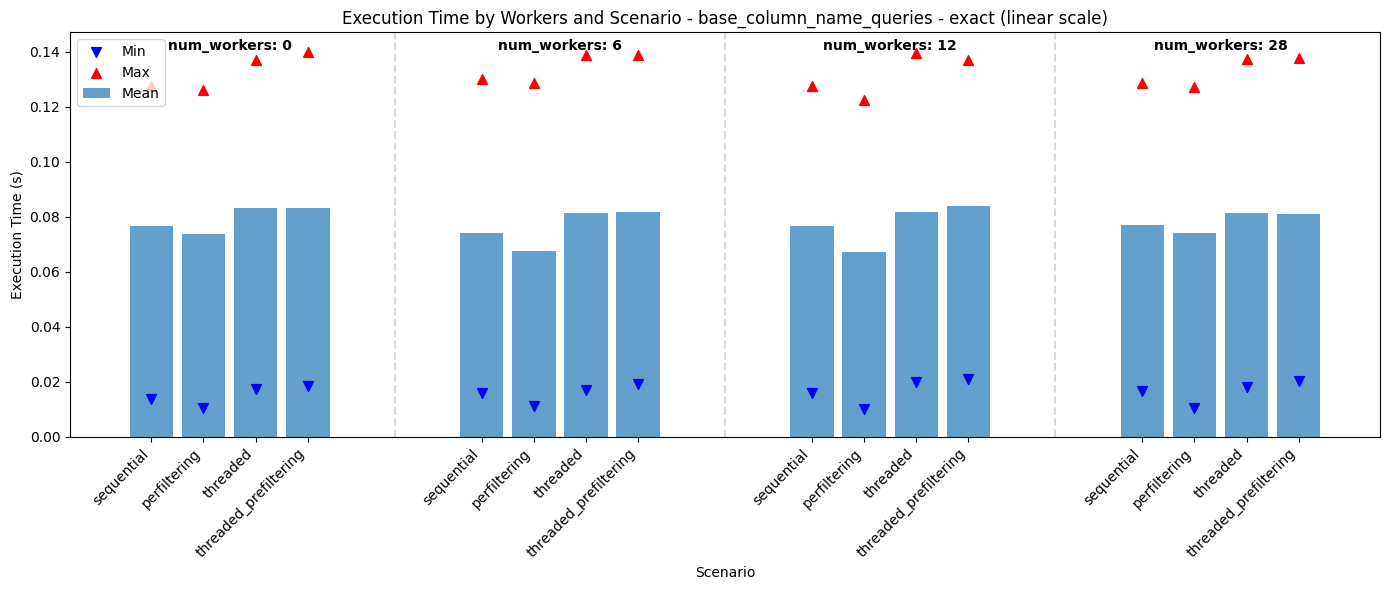

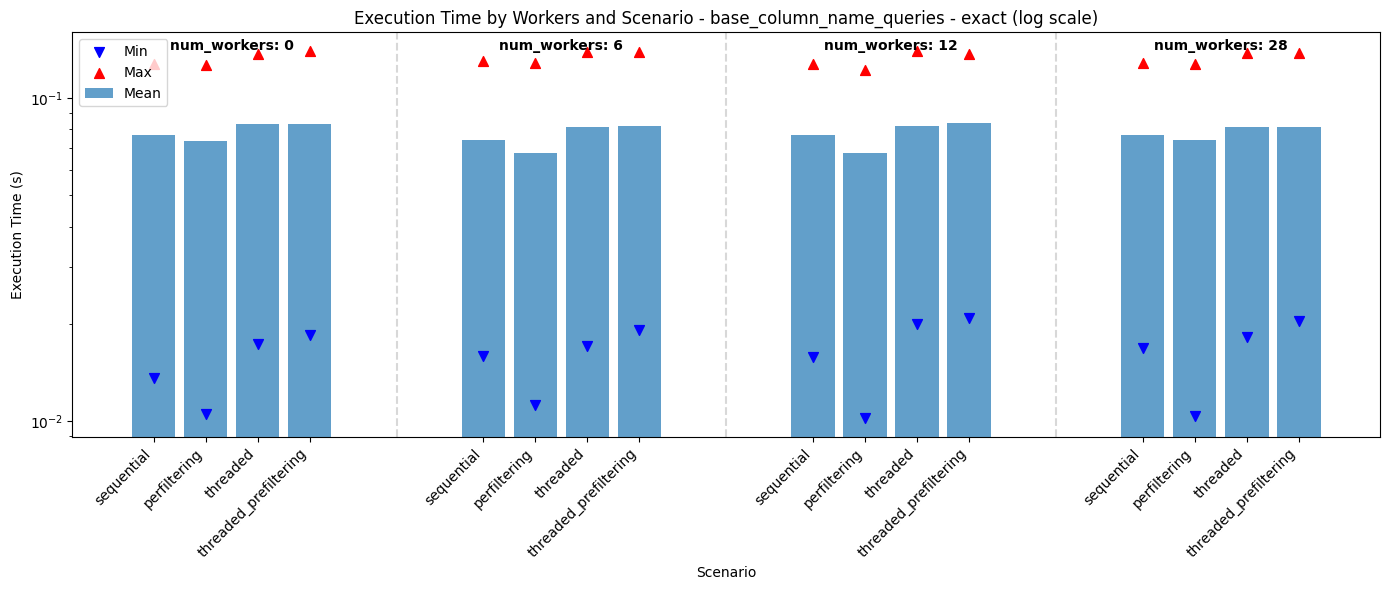

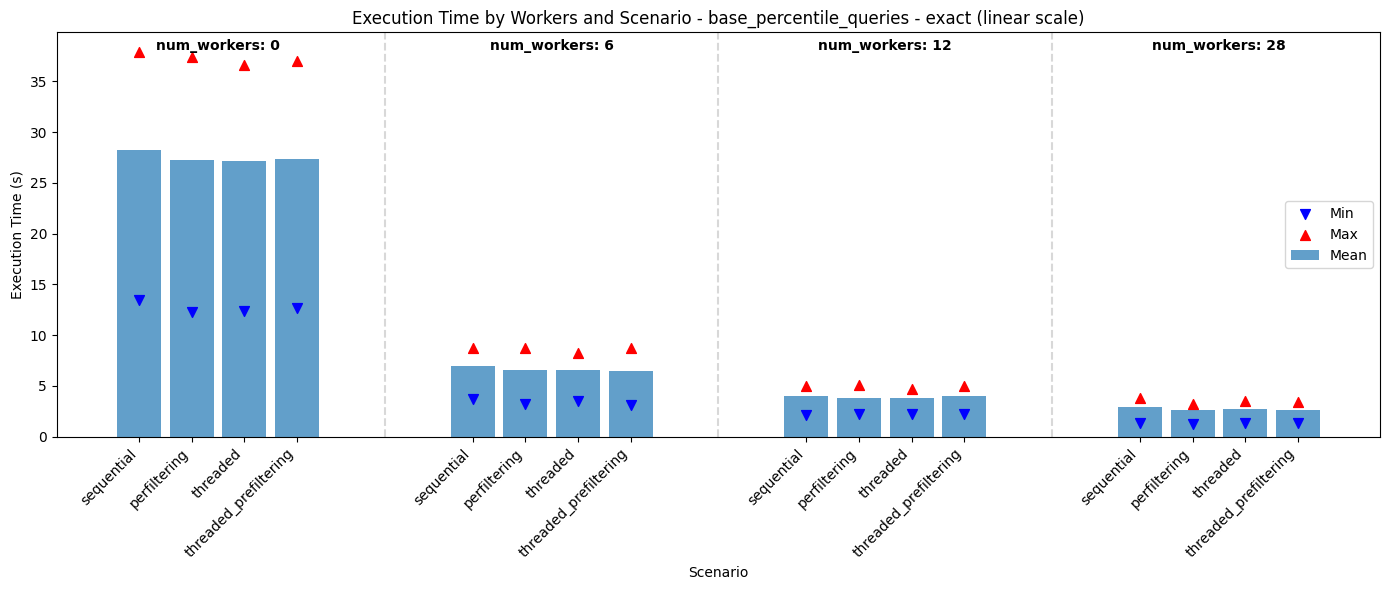

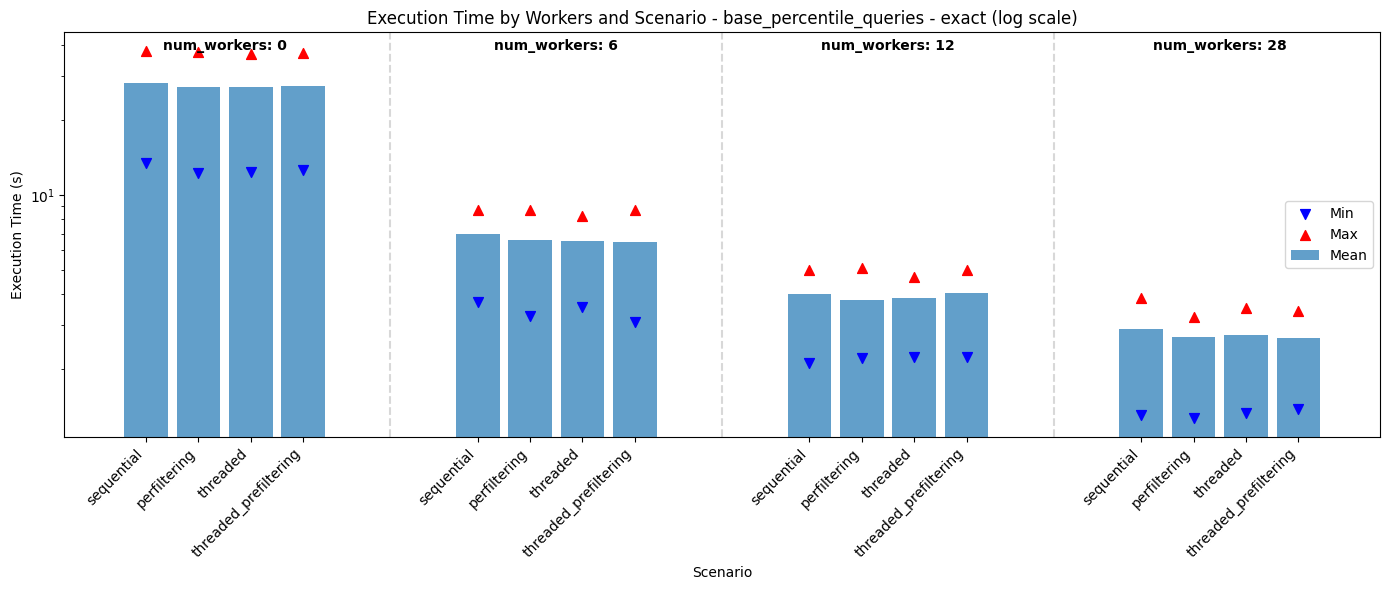

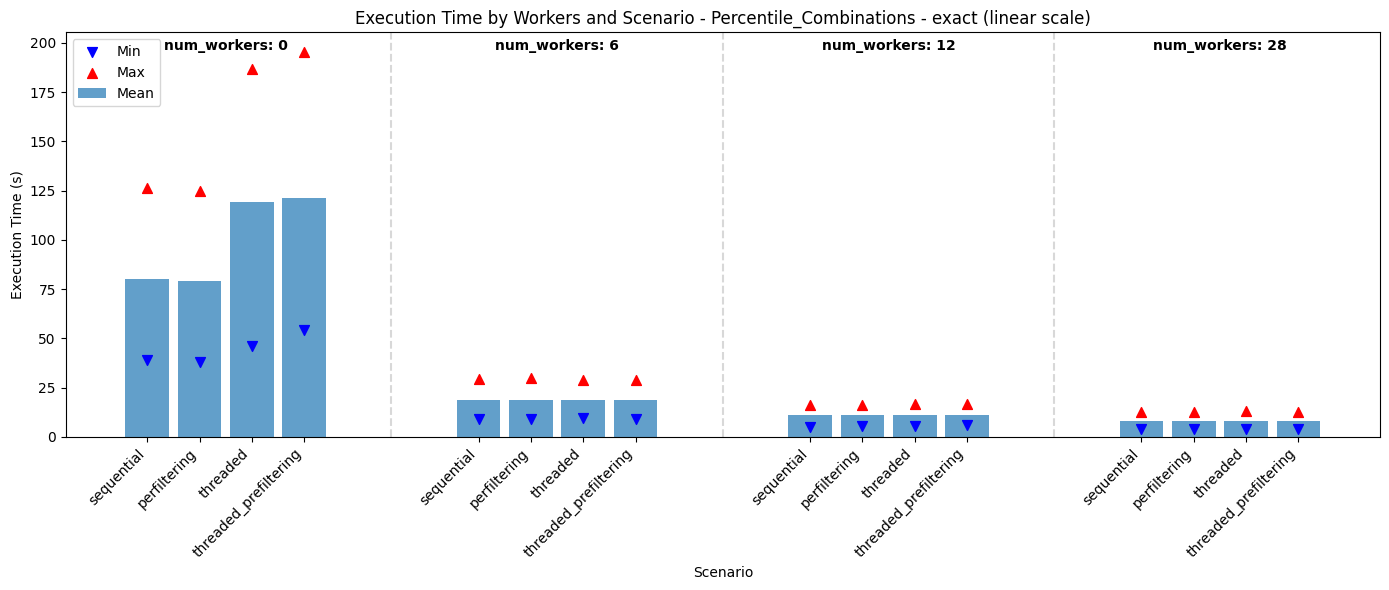

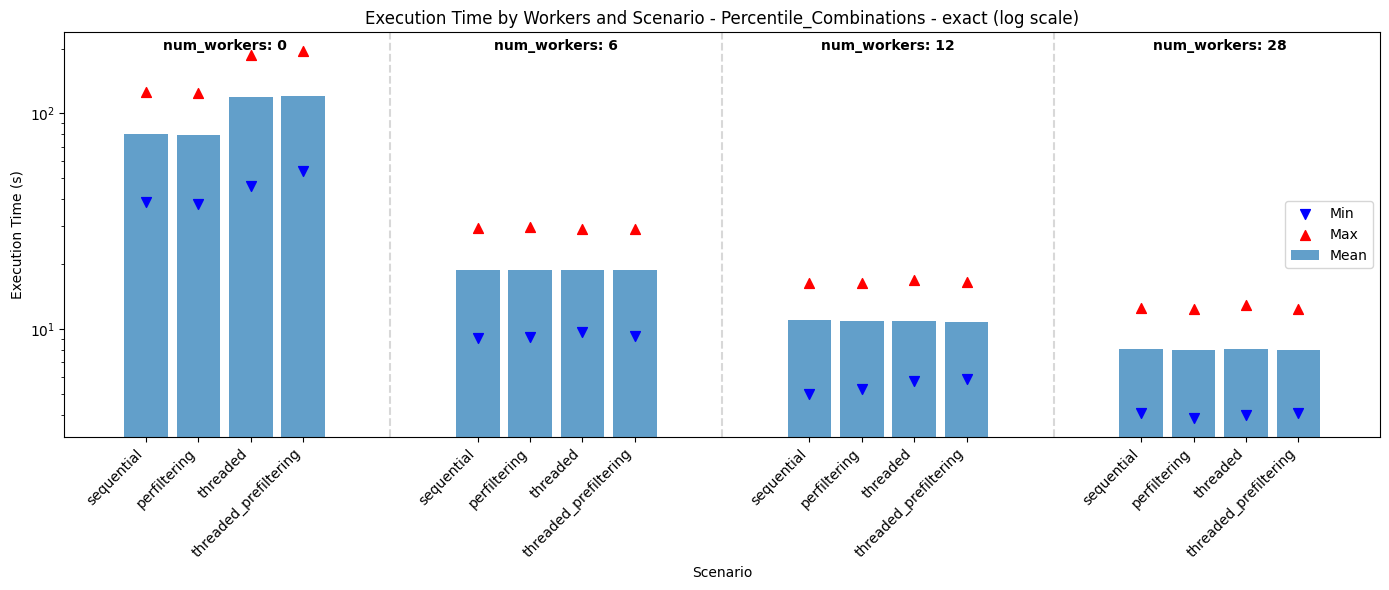

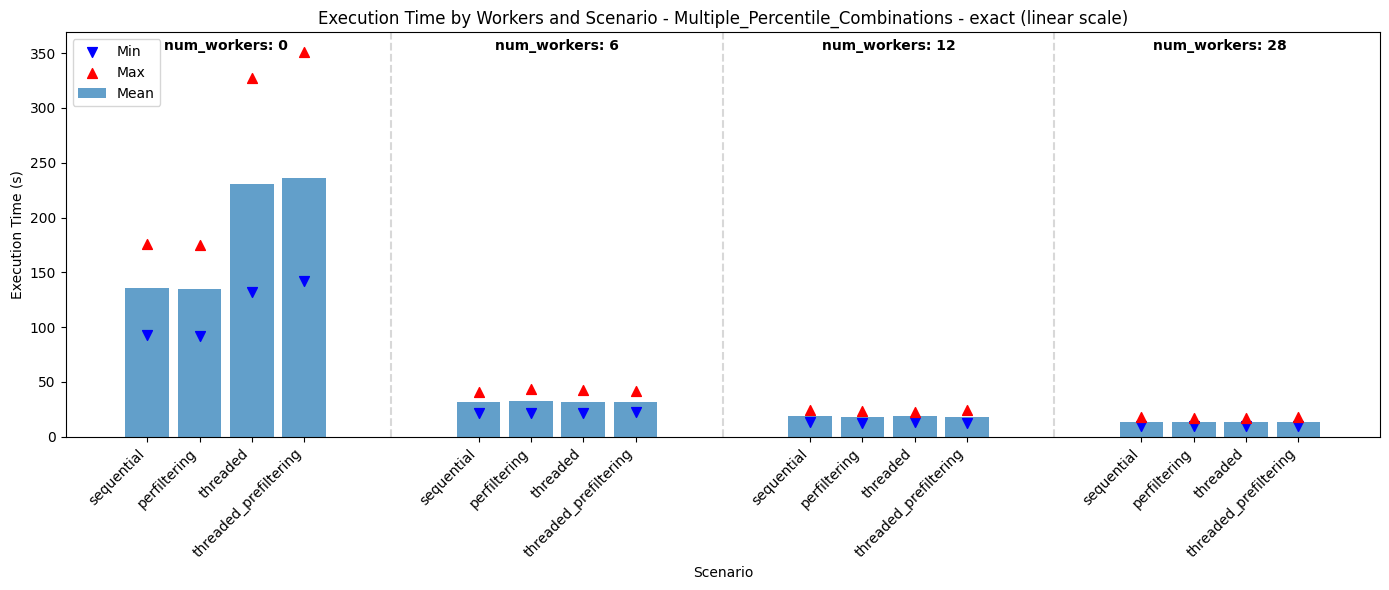

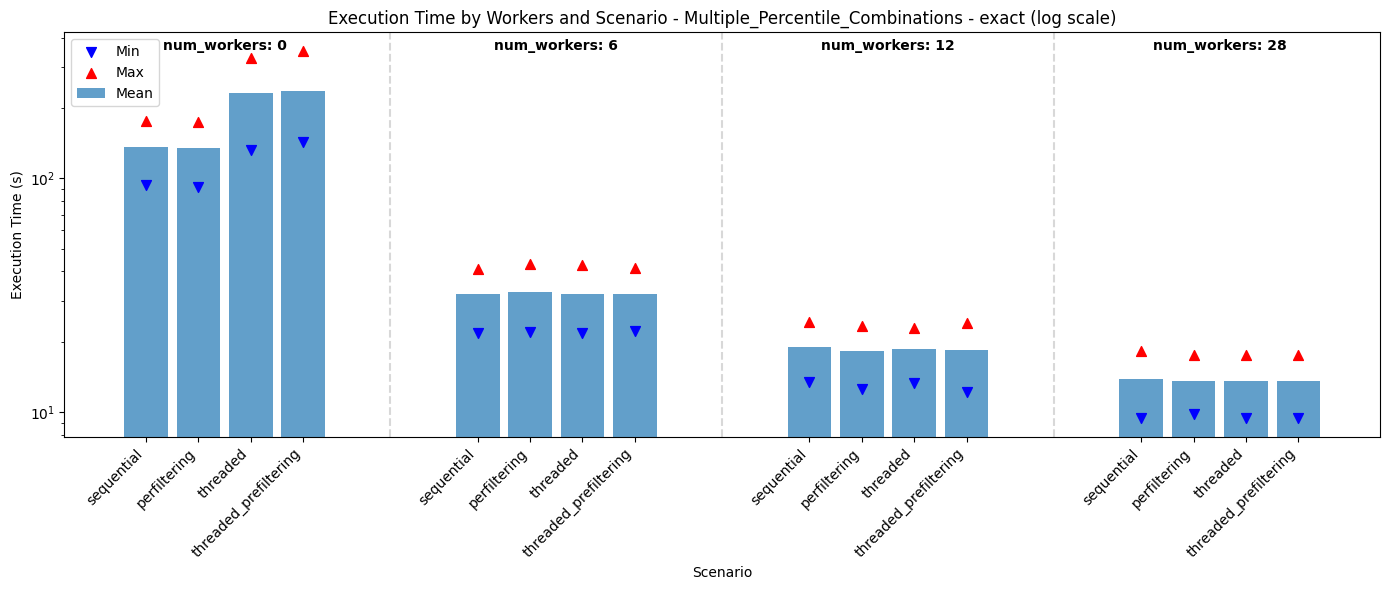

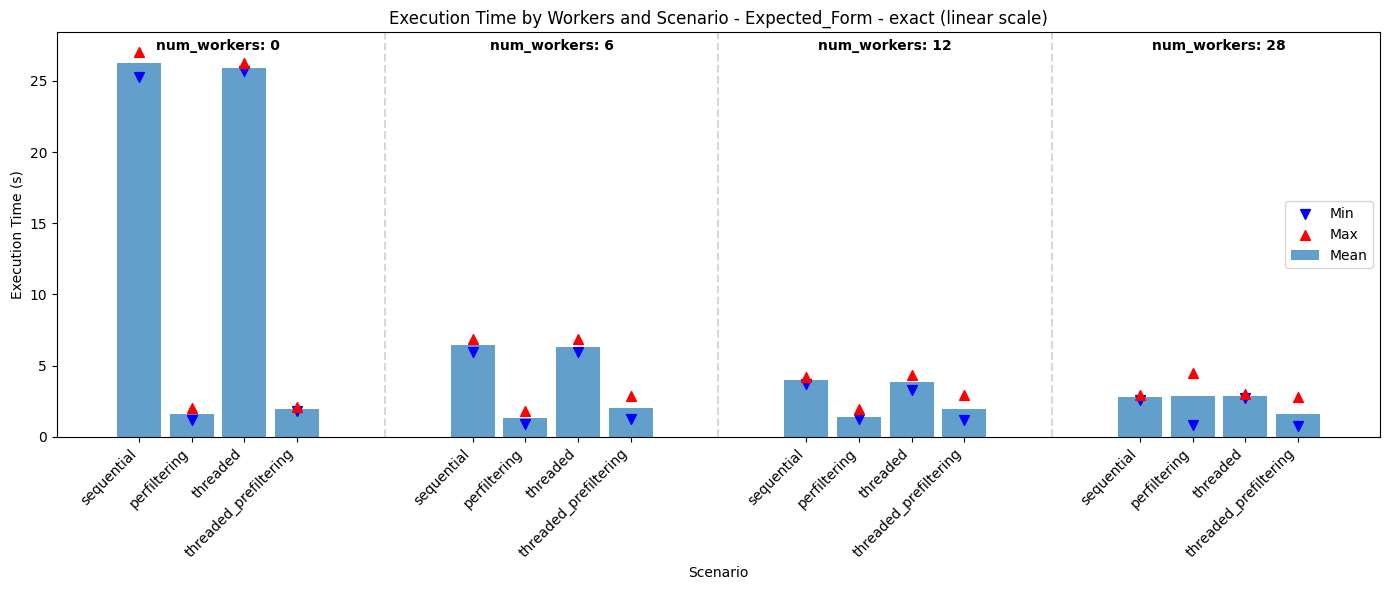

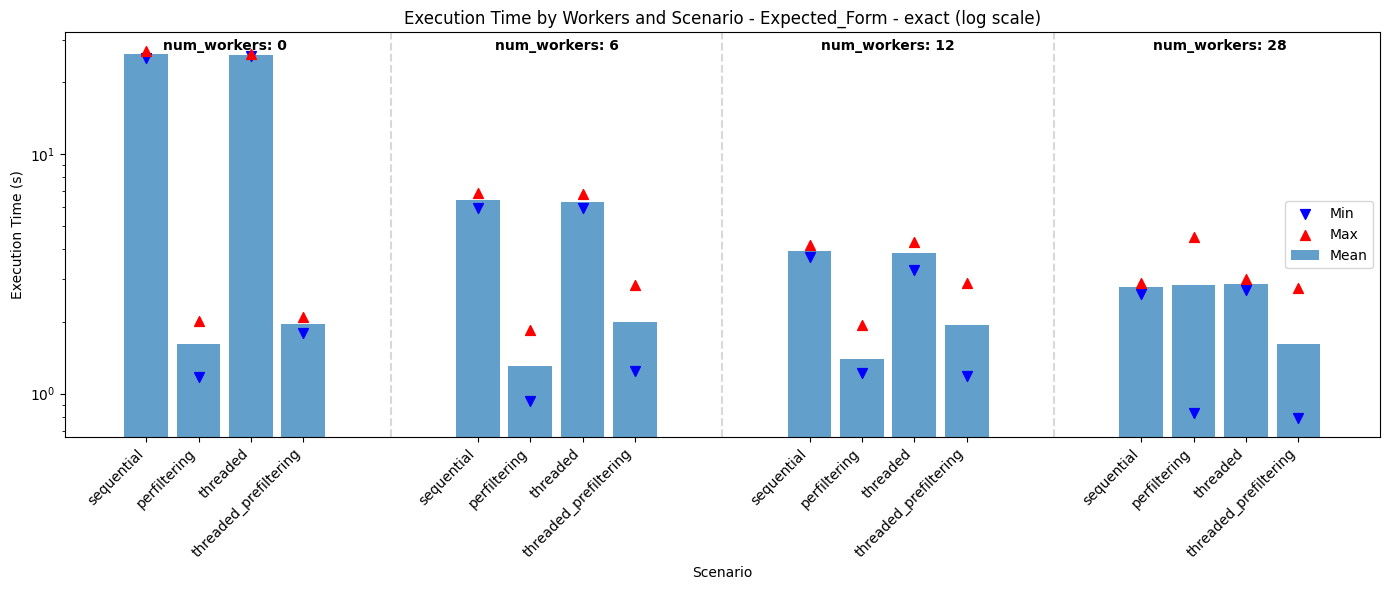

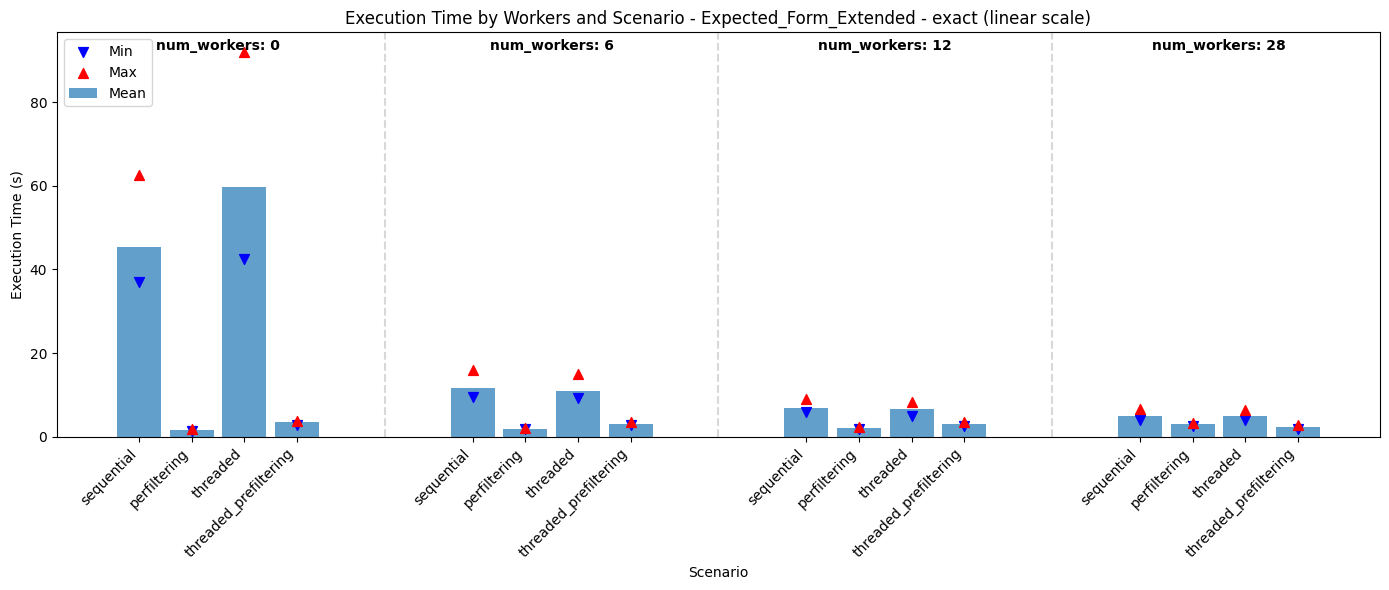

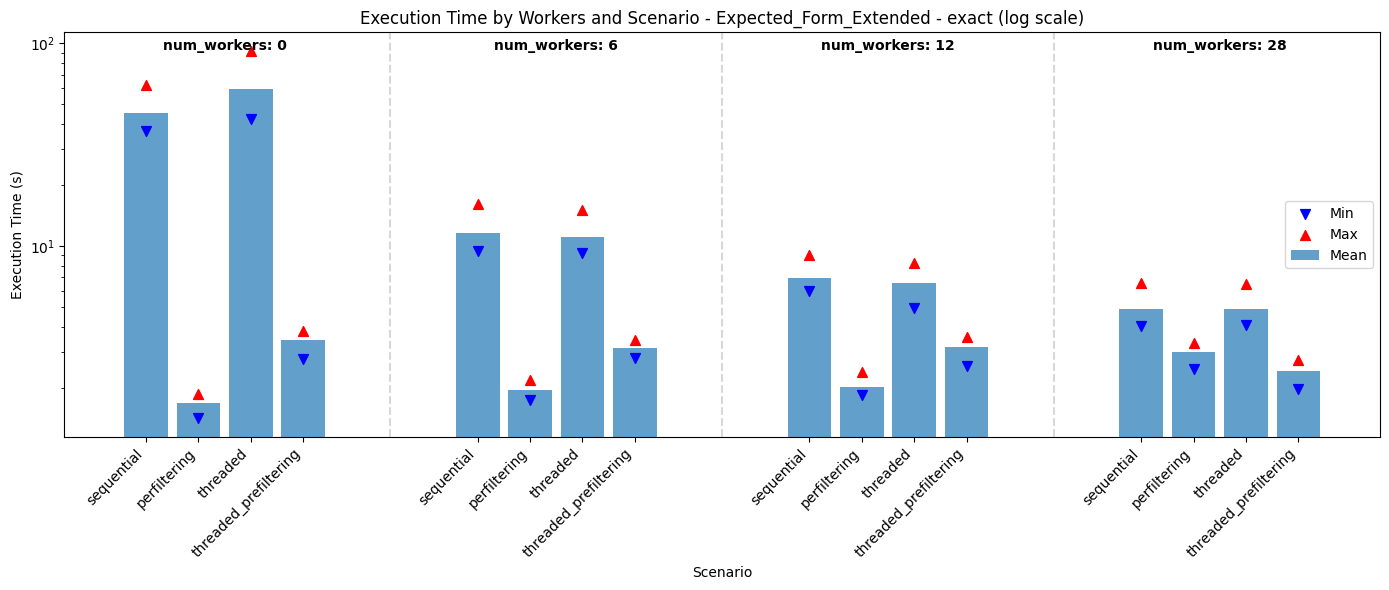

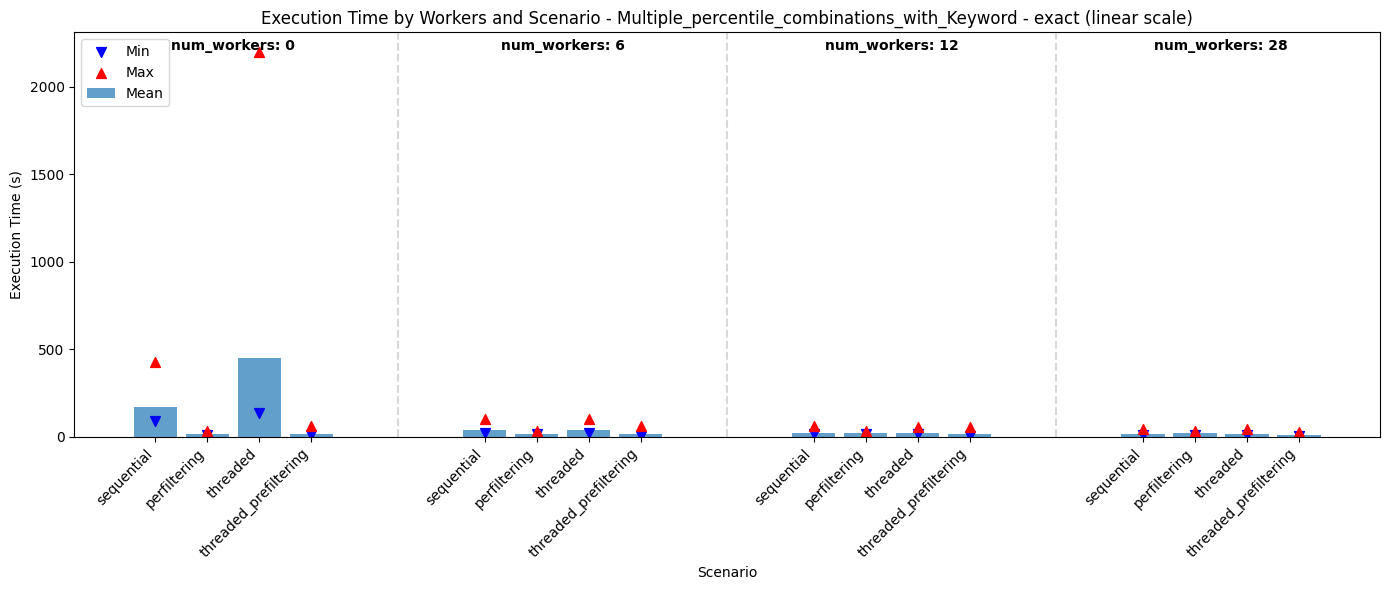

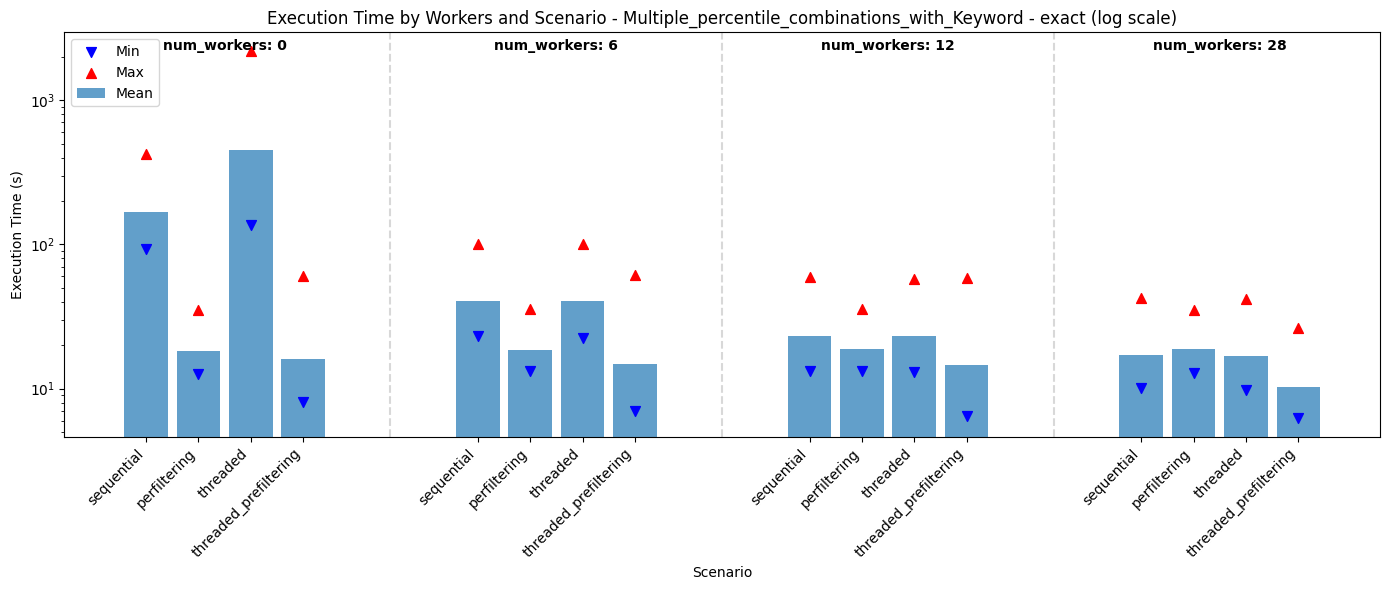

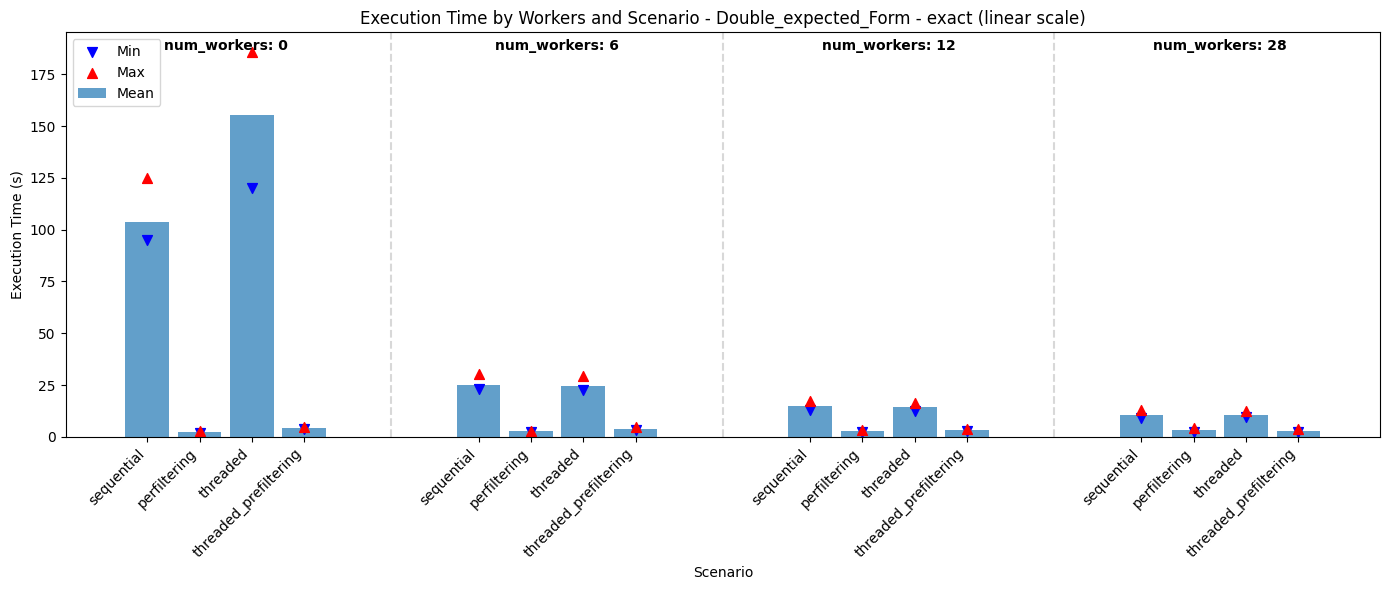

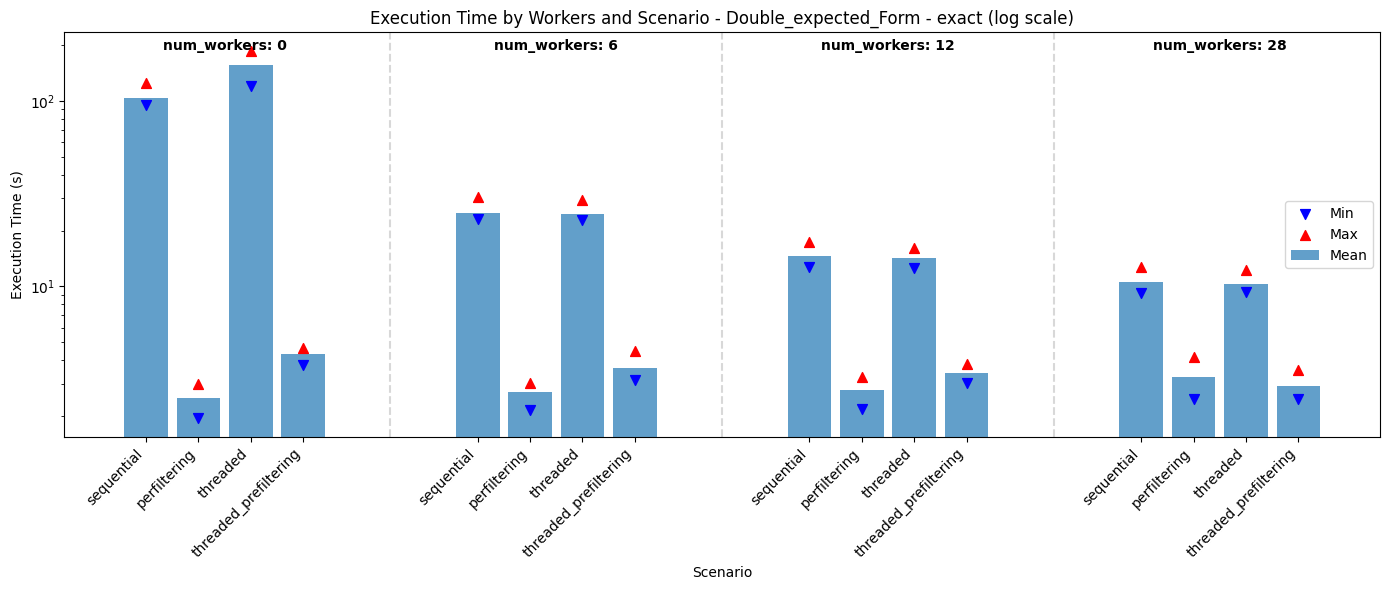

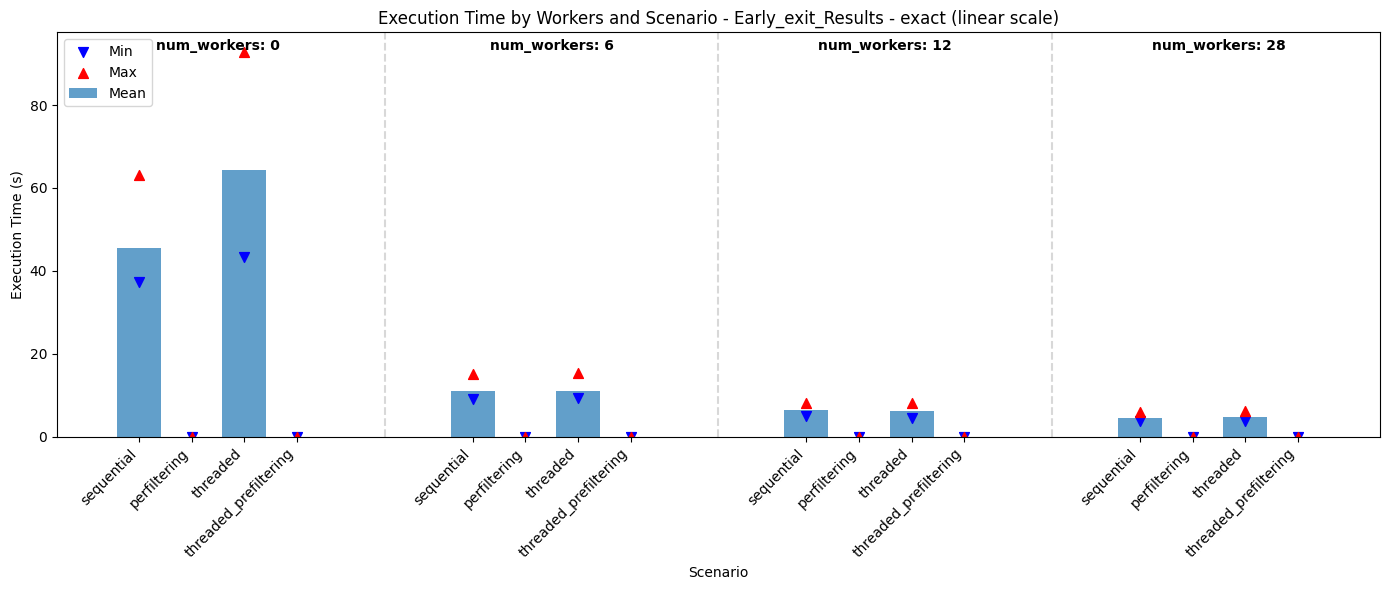

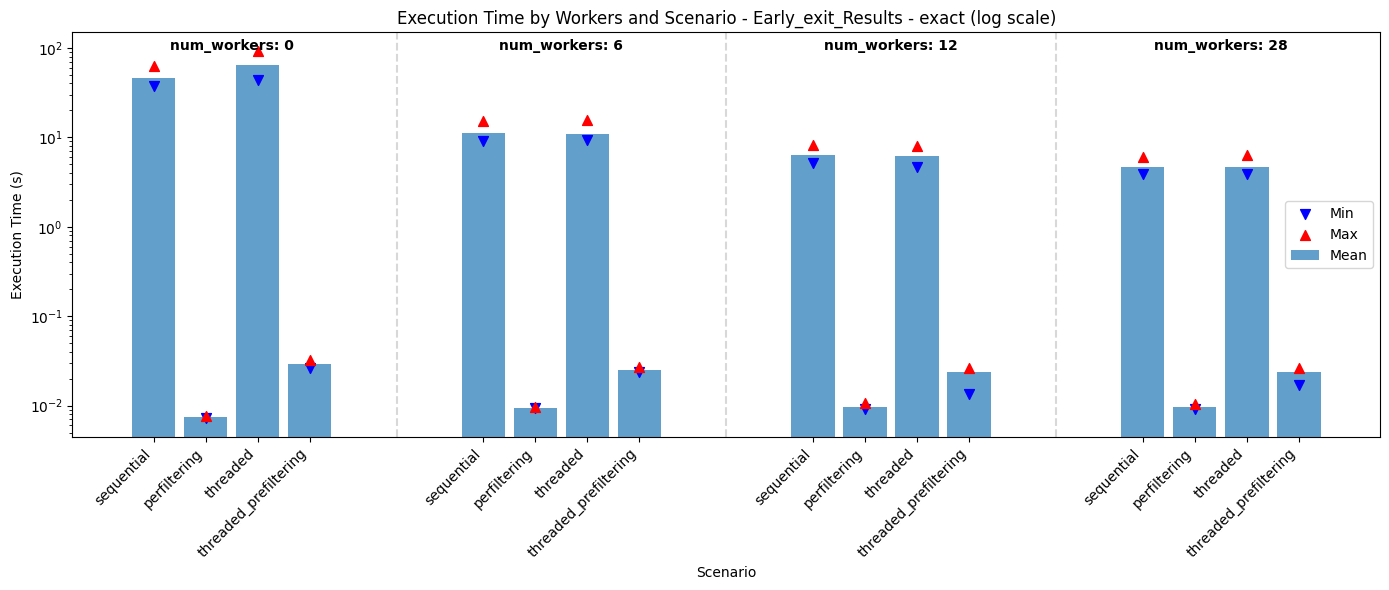

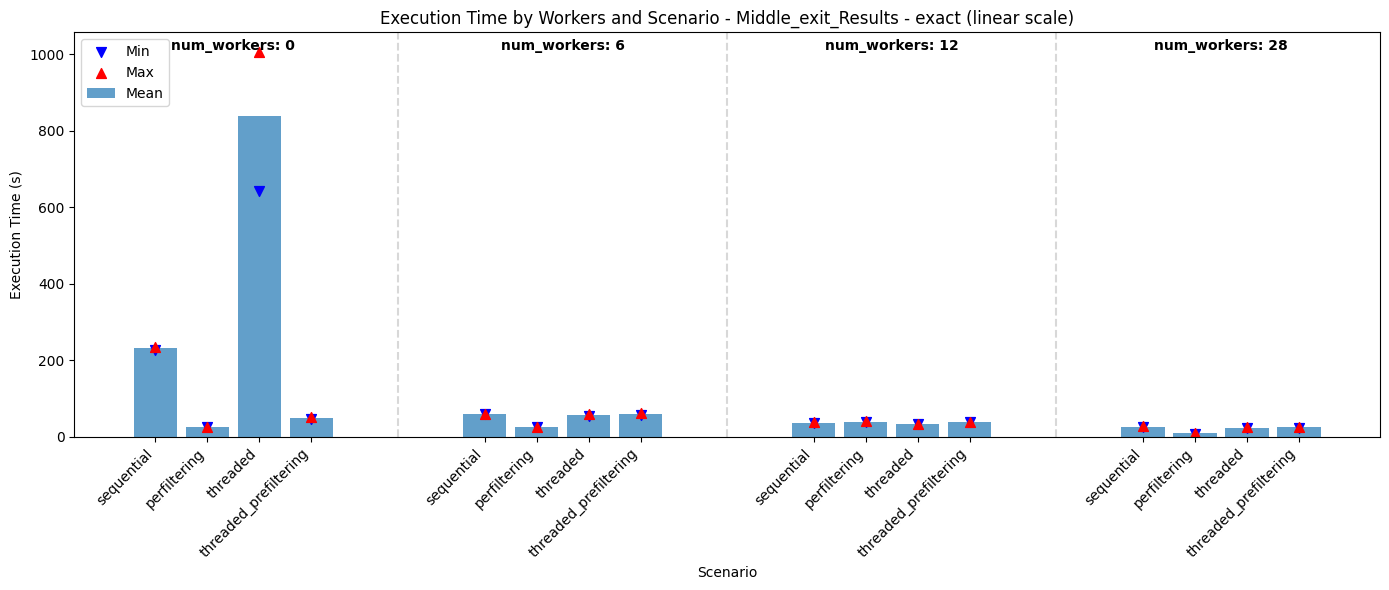

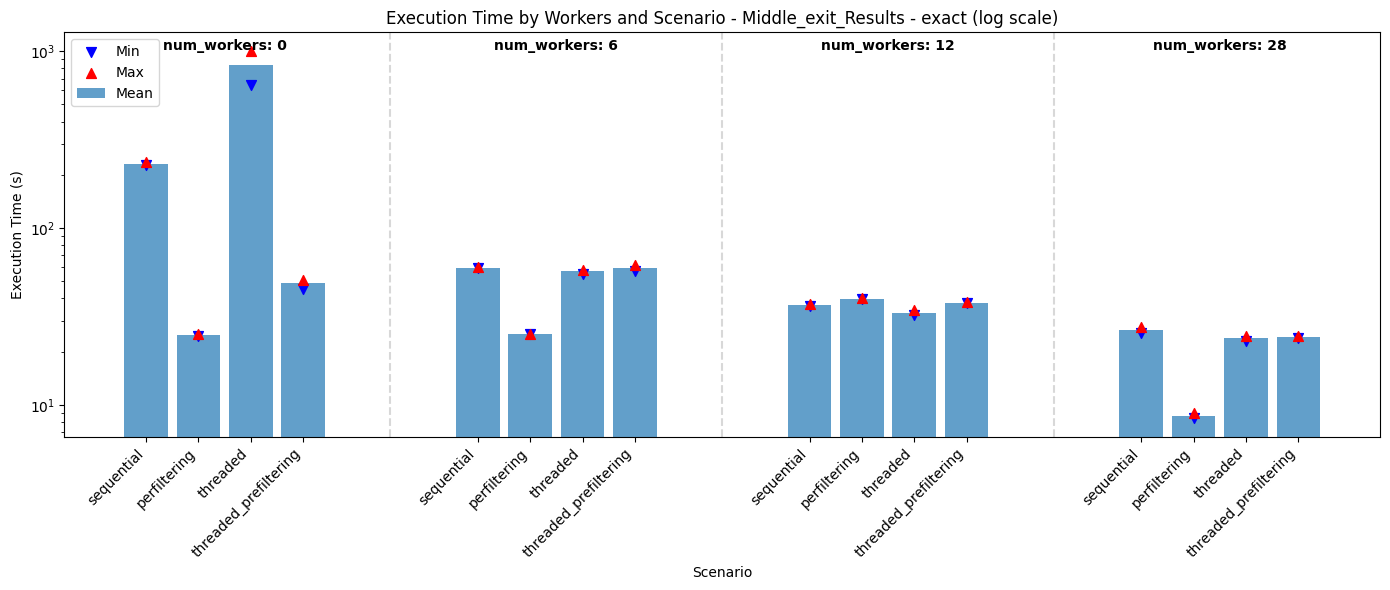

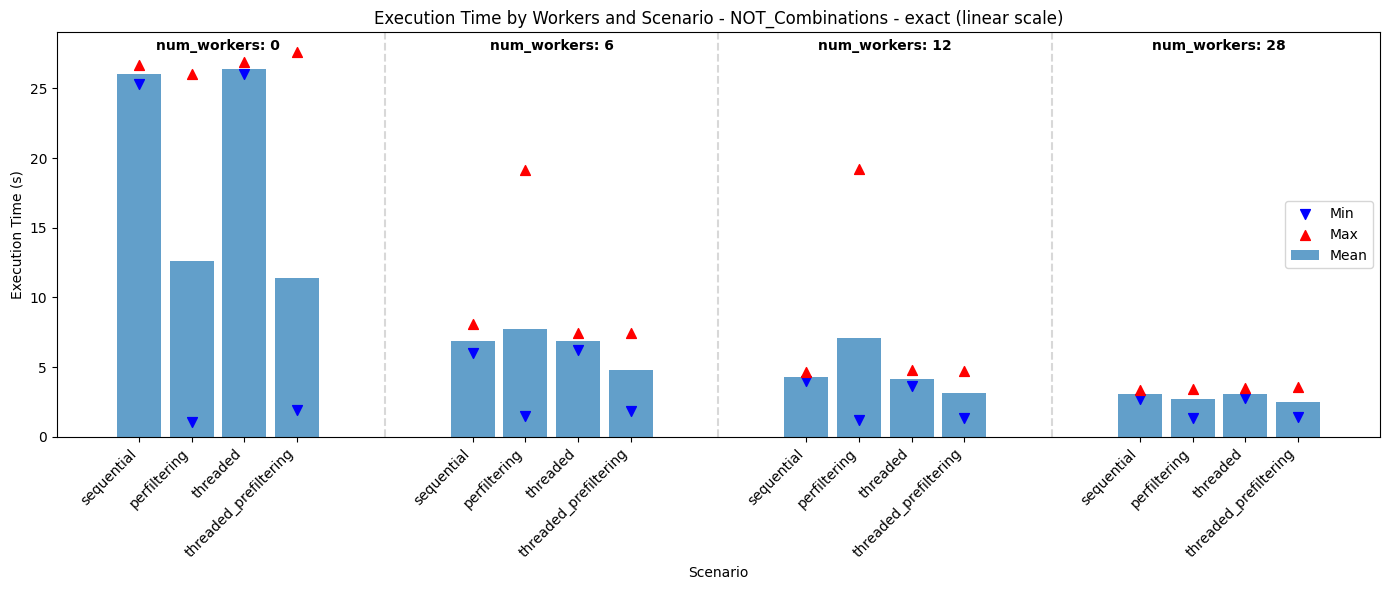

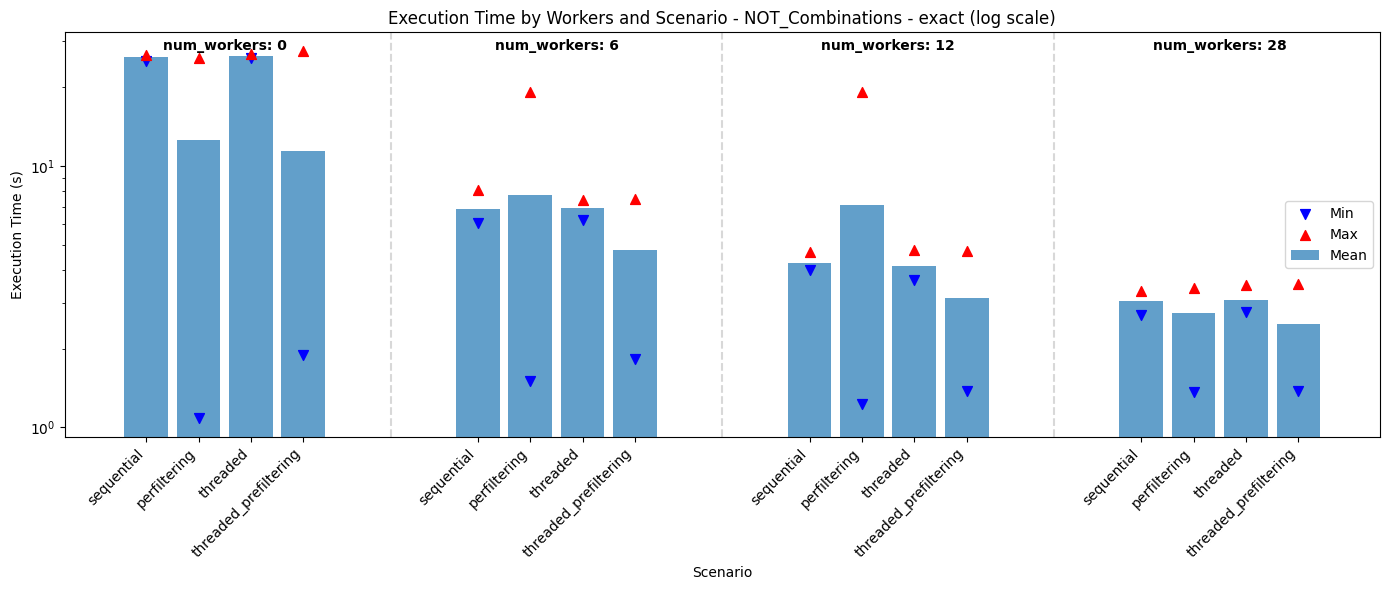

In [11]:
# Compare execution time (y-axis min, max, mean) against scenario and num_workers (x-axis) for one plot per fainder mode per category one plot
categories = df_latest["category"].unique()
fainder_modes = ["exact"]
for category in categories:
    df_category = df_latest[df_latest["category"] == category]

    for fainder_mode in fainder_modes:
        df_fainder_mode = df_category[df_category["fainder_mode"] == fainder_mode]
        
        # Create two figures - one with linear scale, one with log scale
        for scale_type in ["linear", "log"]:
            plt.figure(figsize=(14, 6))
            plt.title(
                f"Execution Time by Workers and Scenario - {category} - {fainder_mode} ({scale_type} scale)"
            )
            plt.xlabel("Scenario")
            plt.ylabel("Execution Time (s)")
            
            # Set log scale if needed
            if scale_type == "log":
                plt.yscale('log')

            # Group first by workers then by scenario
            grouped_data = df_fainder_mode.groupby(["fainder_max_workers", "scenario"])

            # Get unique workers and scenarios
            unique_workers = sorted(df_fainder_mode["fainder_max_workers"].unique())
            unique_scenarios = df_fainder_mode["scenario"].unique()

            # Set up positions for bar groups with smaller separation between same workers
            groups = list(grouped_data.groups.keys())

            # Create a dictionary to map (worker, scenario) to x position
            x_pos_map = {}
            current_x = 0

            for worker in unique_workers:
                # Create positions for this worker's scenarios with small gaps between them
                scenario_positions = [
                    current_x + i * 0.3 for i in range(len(unique_scenarios))
                ]
                for i, scenario in enumerate(unique_scenarios):
                    x_pos_map[(worker, scenario)] = scenario_positions[i]

                # Add larger gap between different worker groups
                current_x = scenario_positions[-1] + 1

            # Get x positions for each group
            x_positions = [x_pos_map[(worker, scenario)] for worker, scenario in groups]

            # Prepare labels
            labels = [f"{workers} - {scenario}" for workers, scenario in groups]

            # Collect data for plotting
            min_times = []
            max_times = []
            mean_times = []

            for (workers, scenario), group in grouped_data:
                execution_times = group["execution_time"]

                # Calculate statistics
                min_times.append(execution_times.min())
                max_times.append(execution_times.max())
                mean_times.append(execution_times.mean())

            # Create bars for mean values
            plt.bar(x_positions, mean_times, width=0.25, alpha=0.7, label="Mean")

            # Add markers for min and max
            plt.scatter(x_positions, min_times, marker="v", color="blue", s=50, label="Min")
            plt.scatter(x_positions, max_times, marker="^", color="red", s=50, label="Max")

            # Add vertical lines to separate worker groups
            current_line_x = -0.5
            for worker in unique_workers[:-1]:  # Don't add line after last worker
                current_line_x = x_pos_map[(worker, unique_scenarios[-1])] + 0.5
                plt.axvline(x=current_line_x, color="gray", linestyle="--", alpha=0.3)

            # Add worker labels centered for each group
            for worker in unique_workers:
                first_x = x_pos_map[(worker, unique_scenarios[0])]
                last_x = x_pos_map[(worker, unique_scenarios[-1])]
                
                # worker underneath the top of the y-axis
                if scale_type == "log":
                    y_bottom, y_top = plt.ylim()
                    y_pos = np.exp(np.log(y_top) - (np.log(y_top) - np.log(y_bottom)) * 0.05)  
                else:
                    y_pos = plt.ylim()[1] * 0.95
                
                plt.text(
                    (first_x + last_x) / 2,
                    y_pos,
                    f"num_workers: {worker}",
                    ha="center",
                    va="bottom",
                    fontsize=10,
                    fontweight="bold",
                )

            # Set the x-tick labels to scenario names (not workers)
            plt.xticks(
                x_positions, [scenario for _, scenario in groups], rotation=45, ha="right"
            )

            plt.legend()
            plt.tight_layout()
            if scale_type == "linear":
                plt.savefig(
                    f"figures/analysis/{category}_{fainder_mode}_by_workers_scenario.png"
                )
            else:
                plt.savefig(
                    f"figures/analysis/{category}_{fainder_mode}_by_workers_scenario_{scale_type}.png"
                )

/tmp/ipykernel_57181/2224562481.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


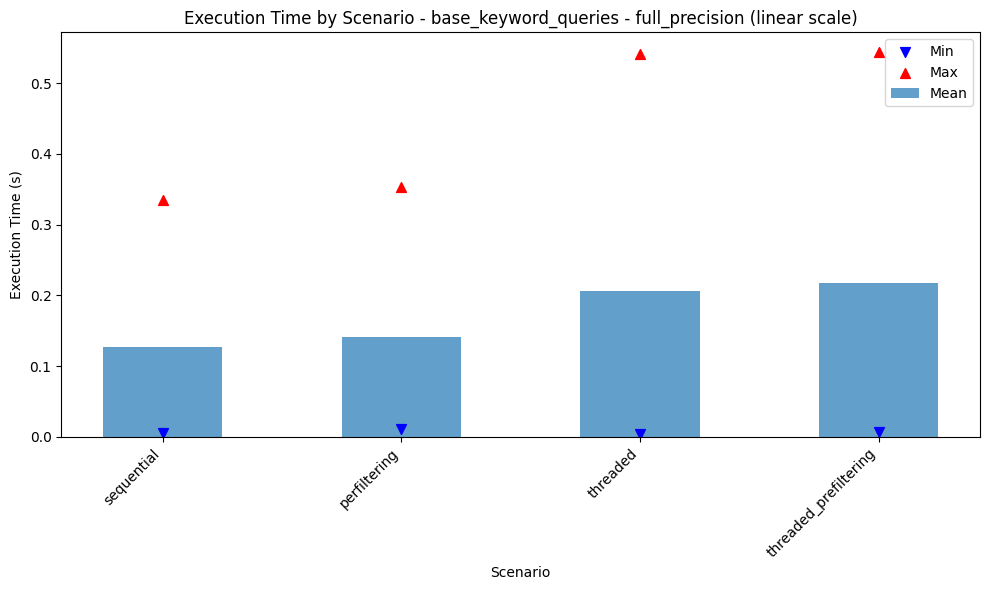

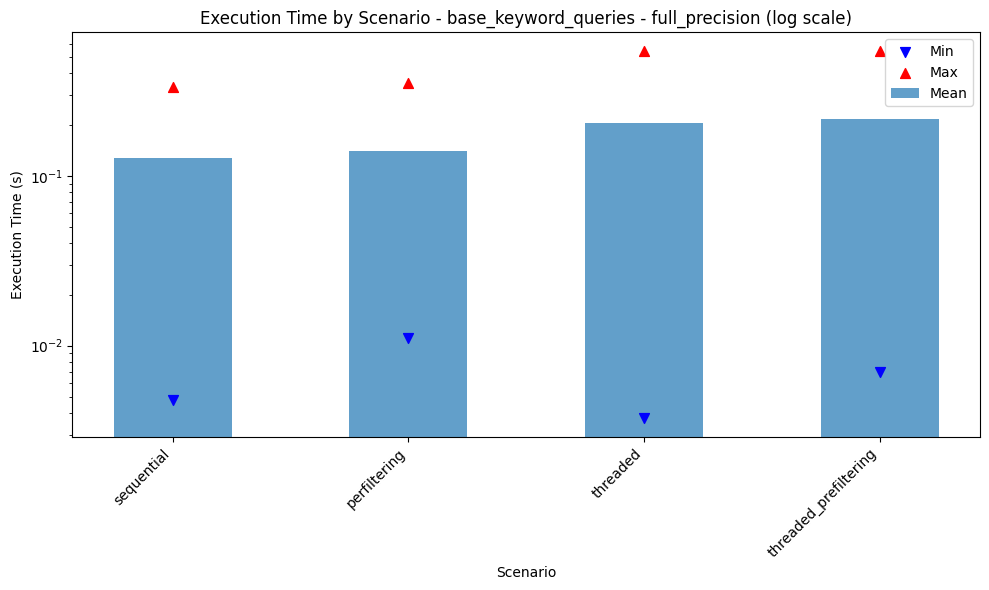

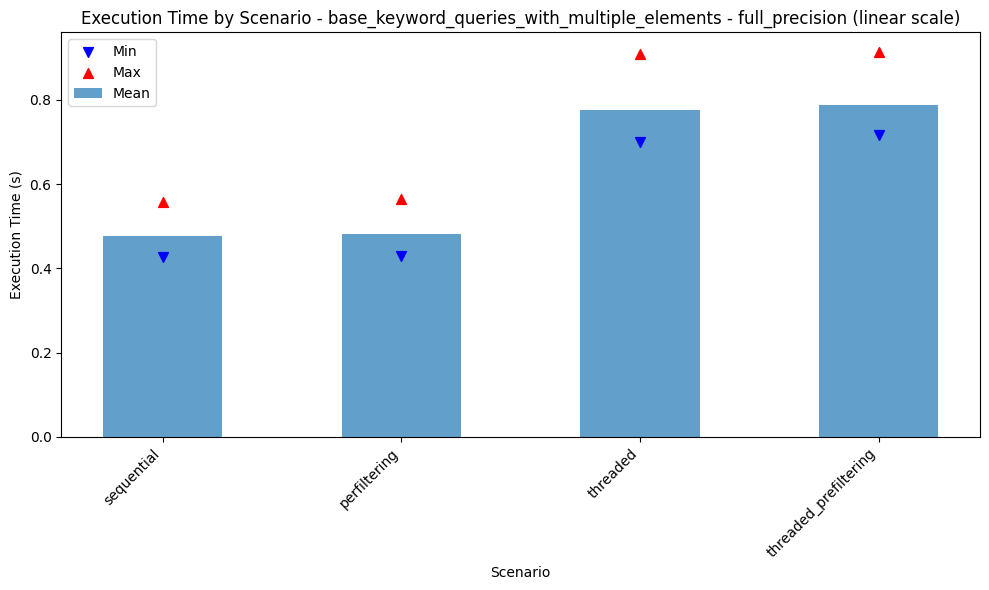

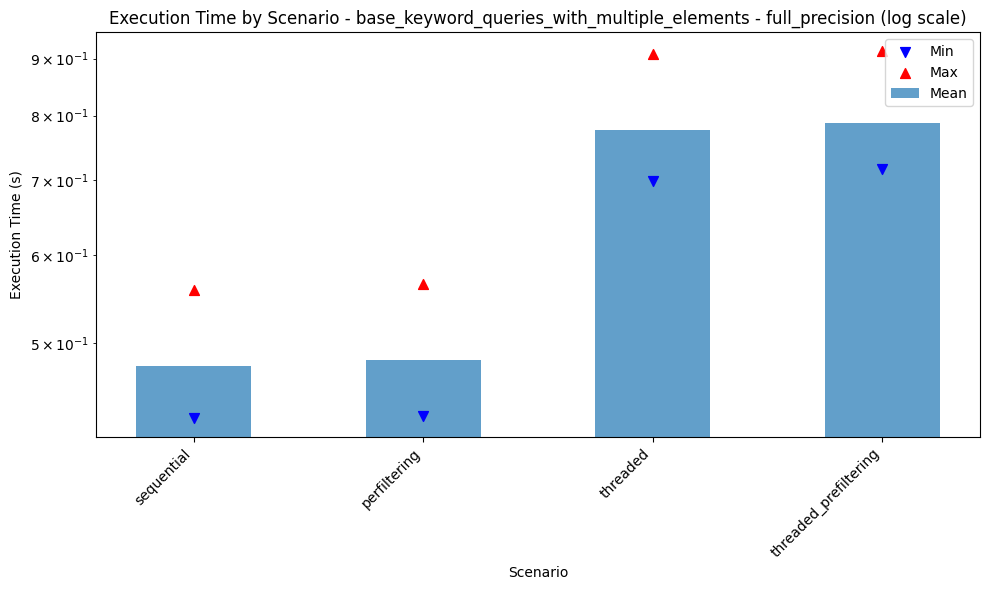

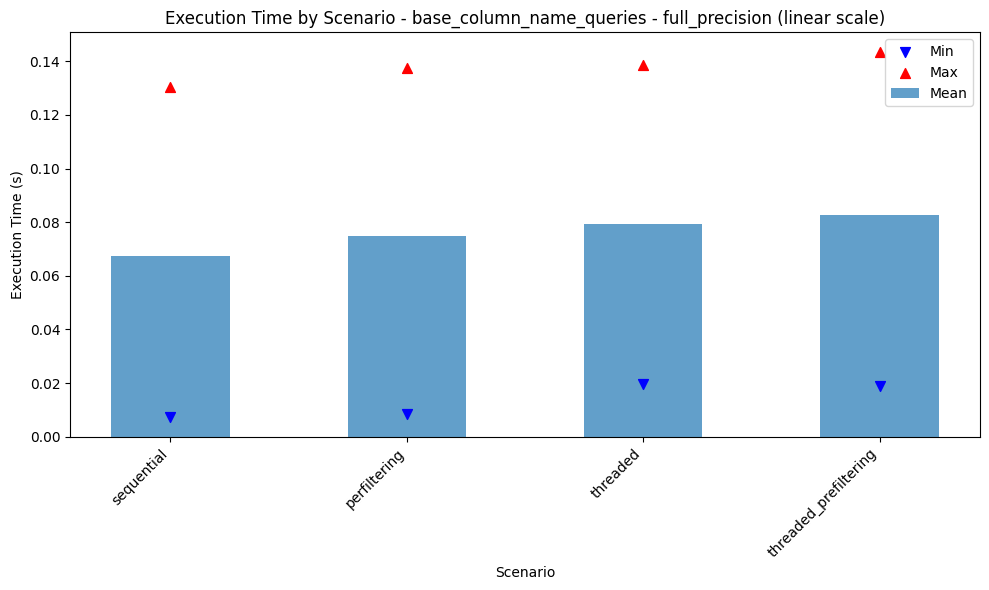

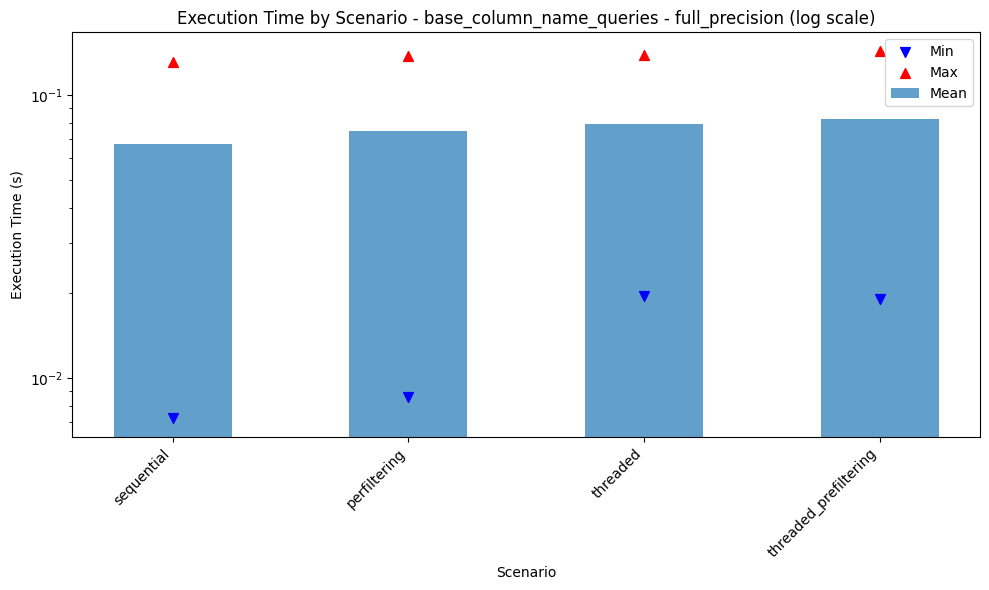

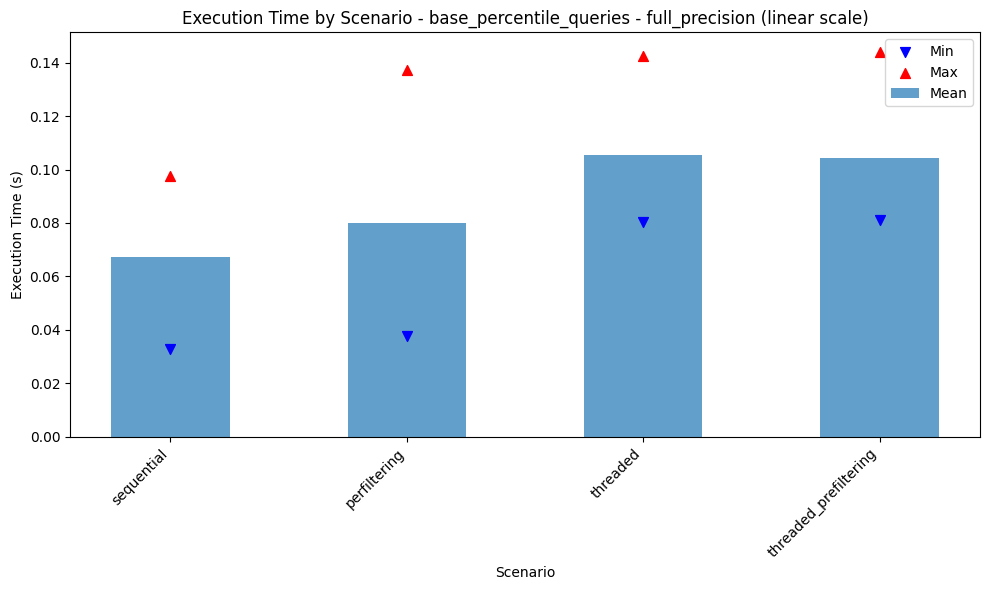

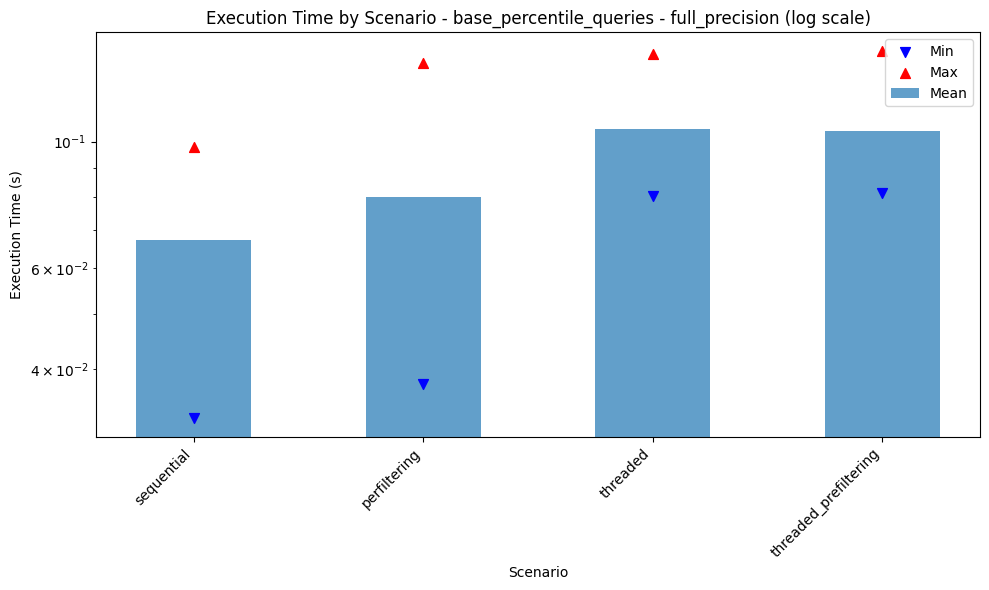

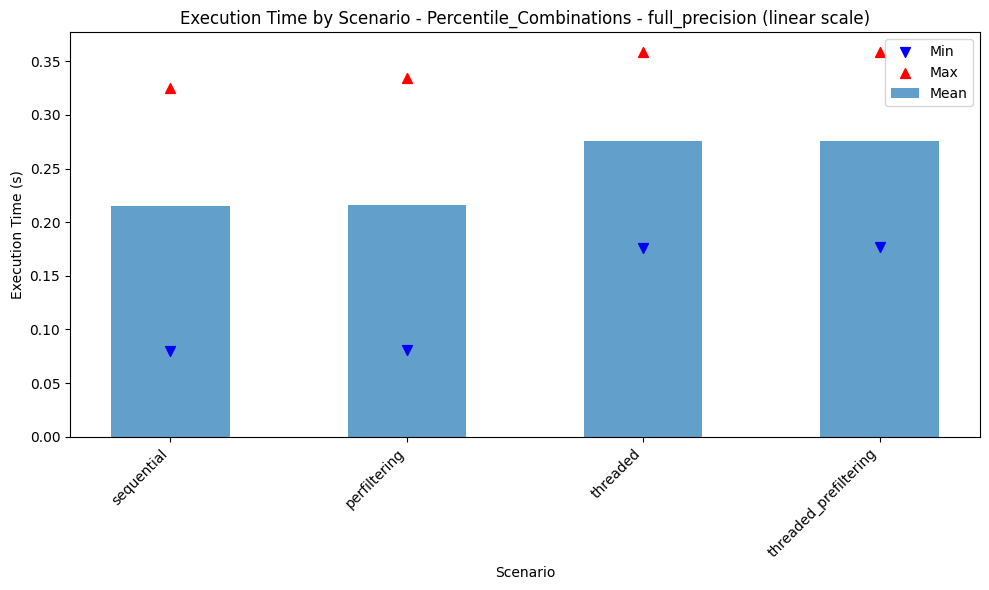

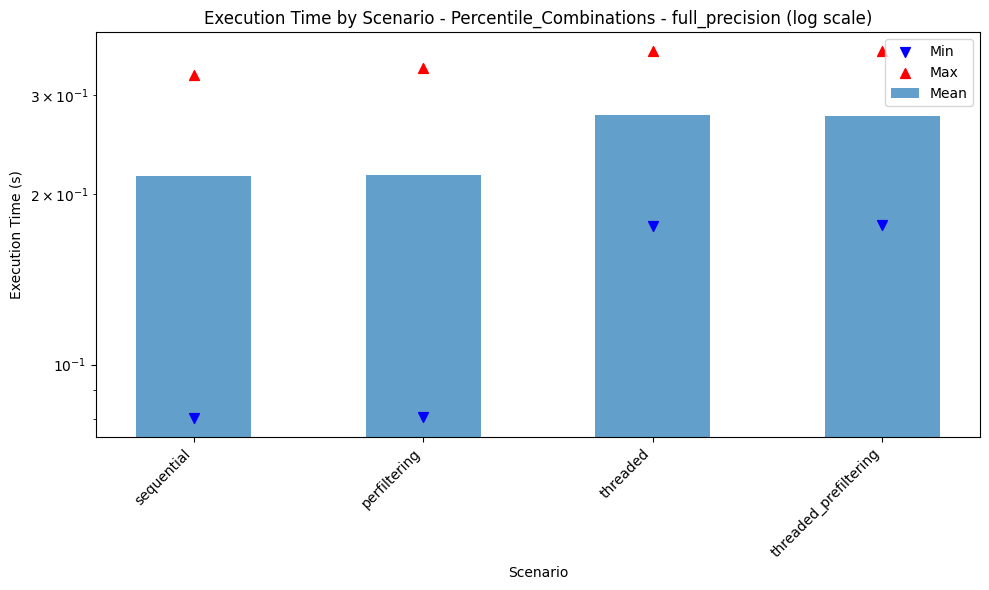

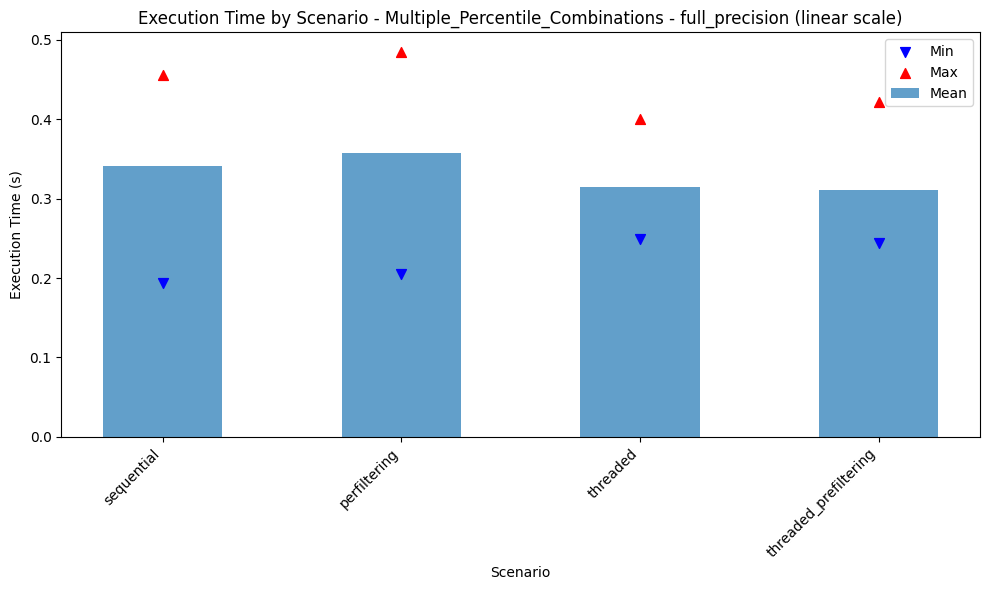

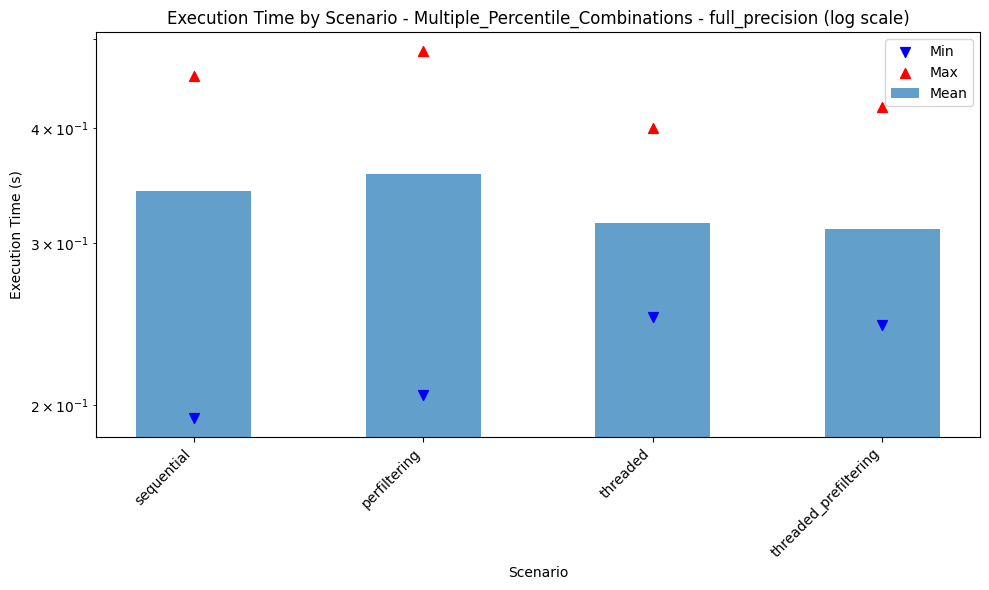

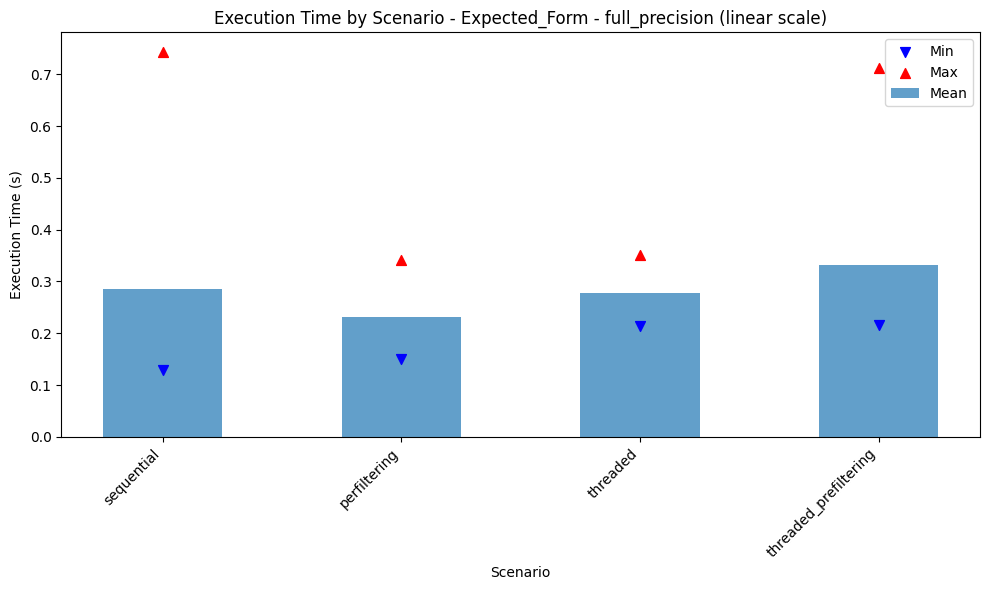

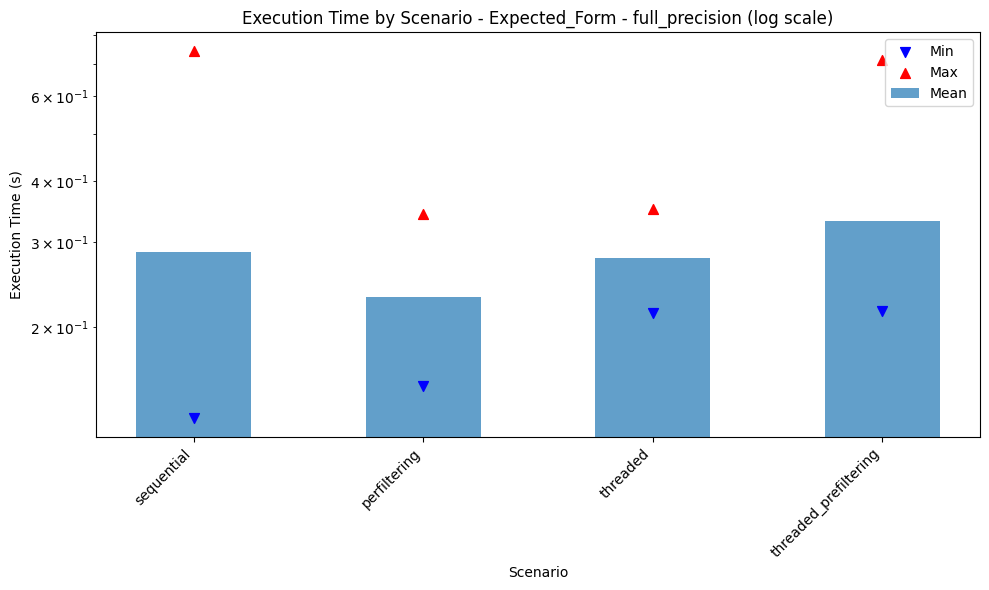

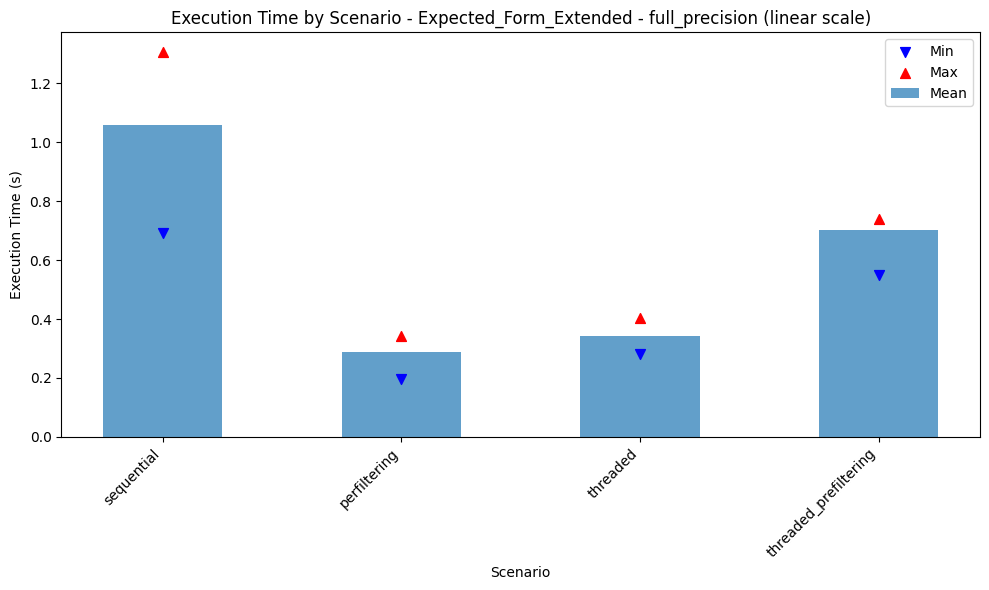

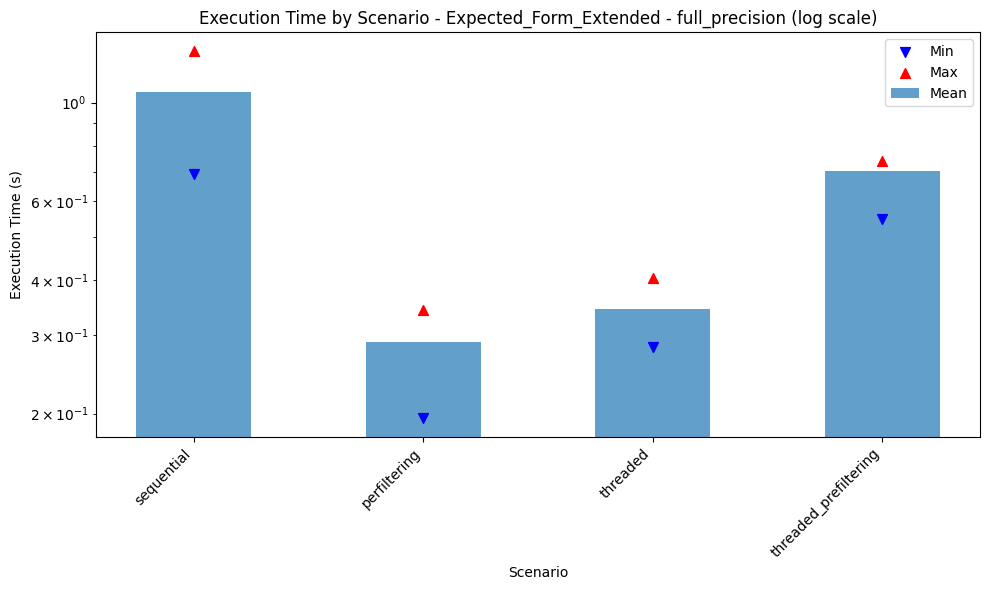

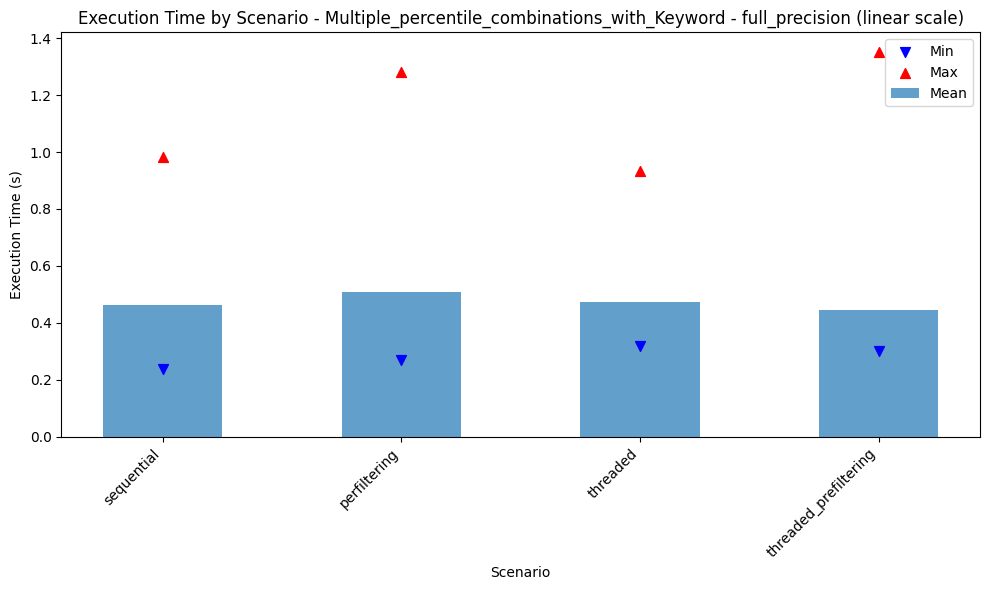

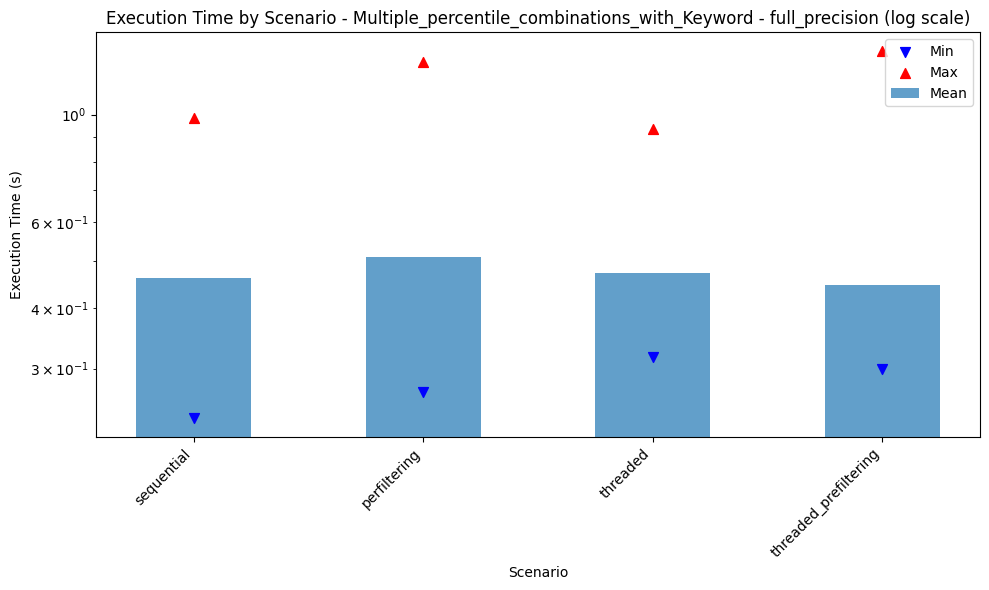

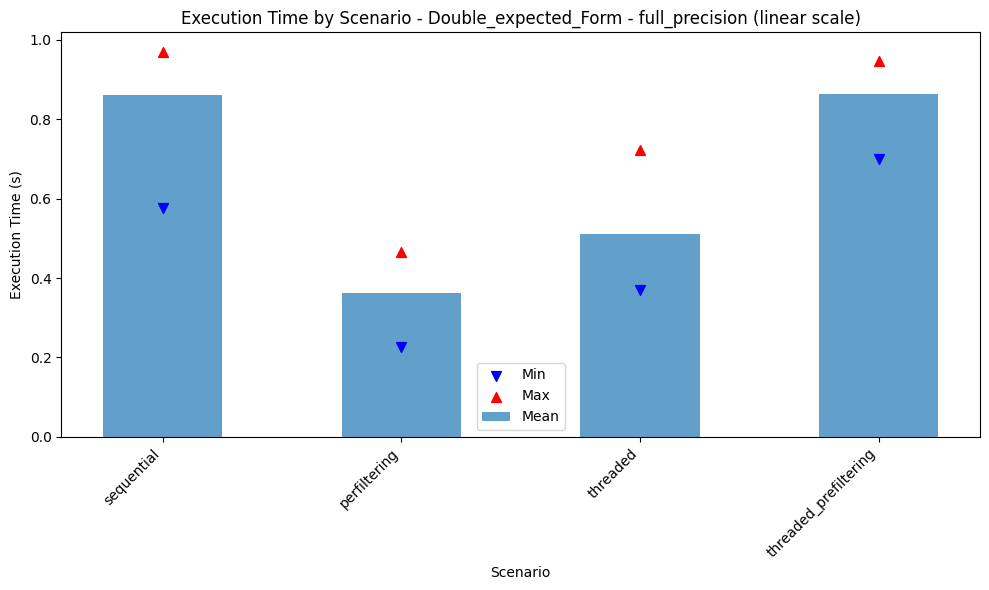

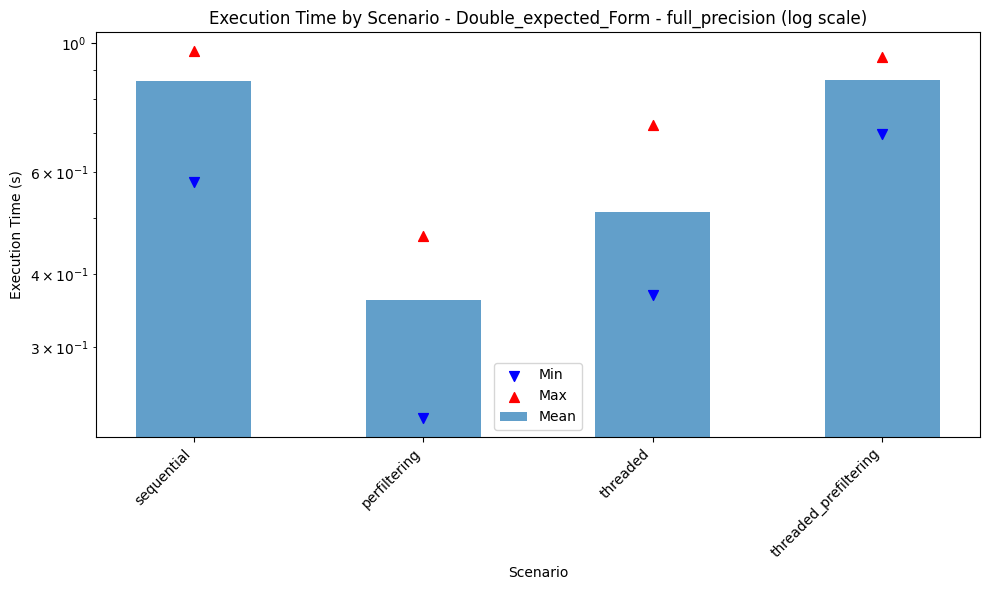

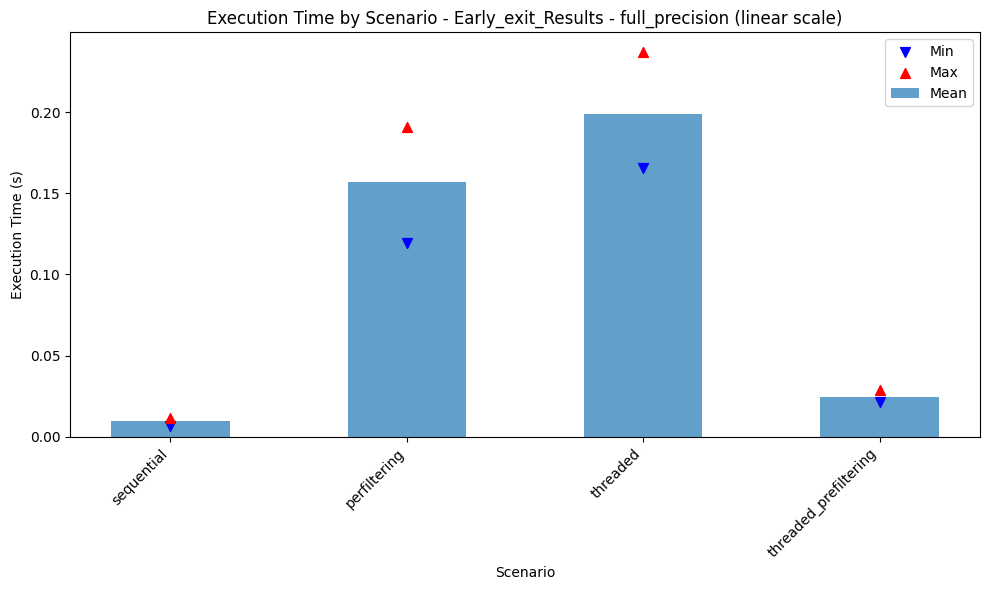

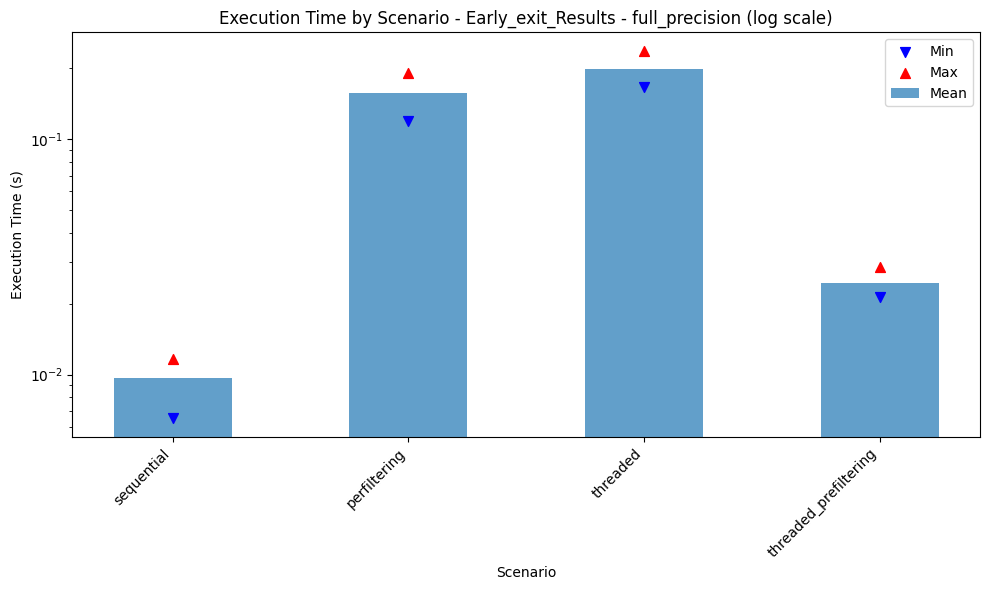

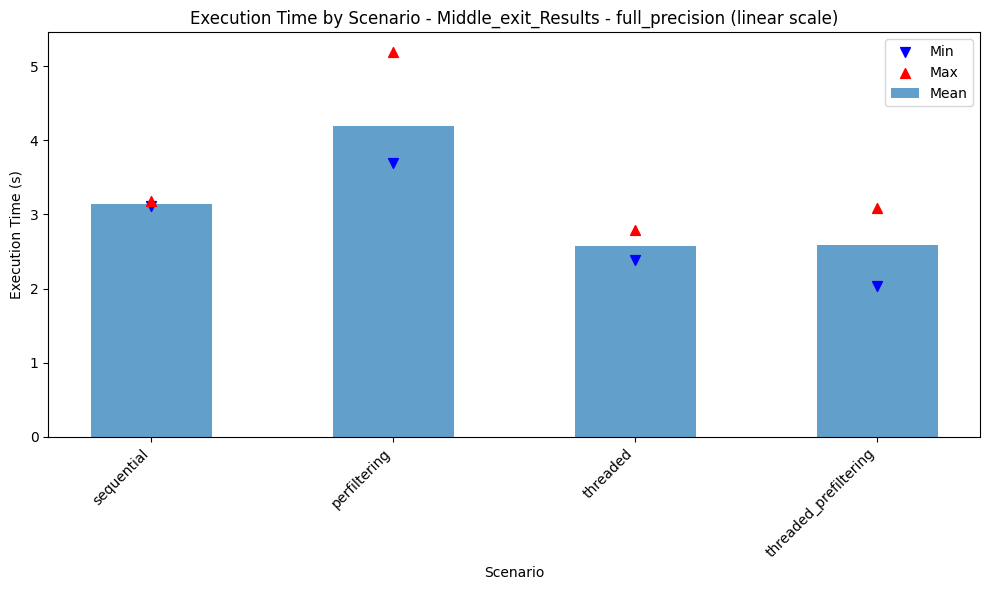

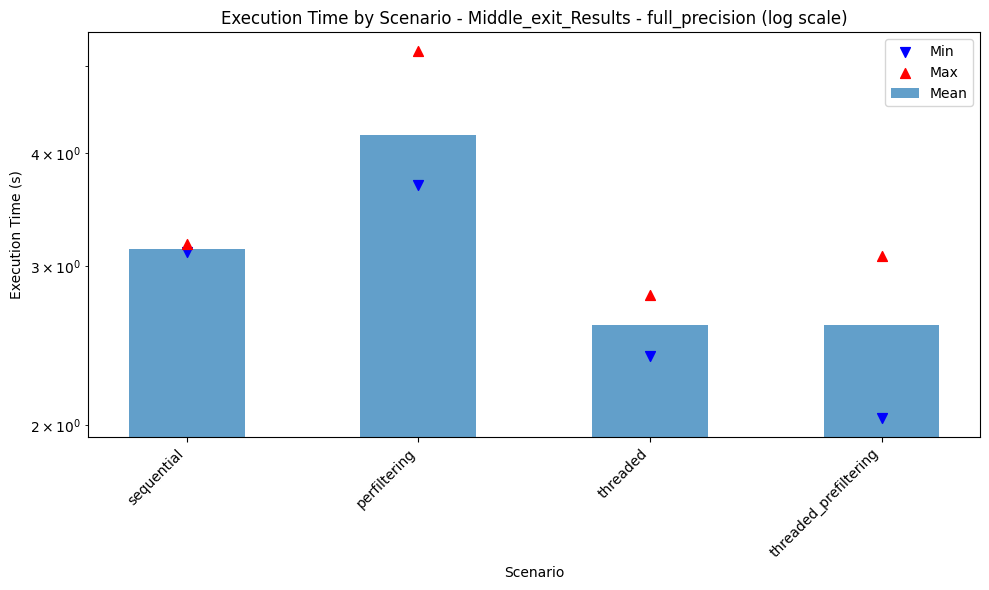

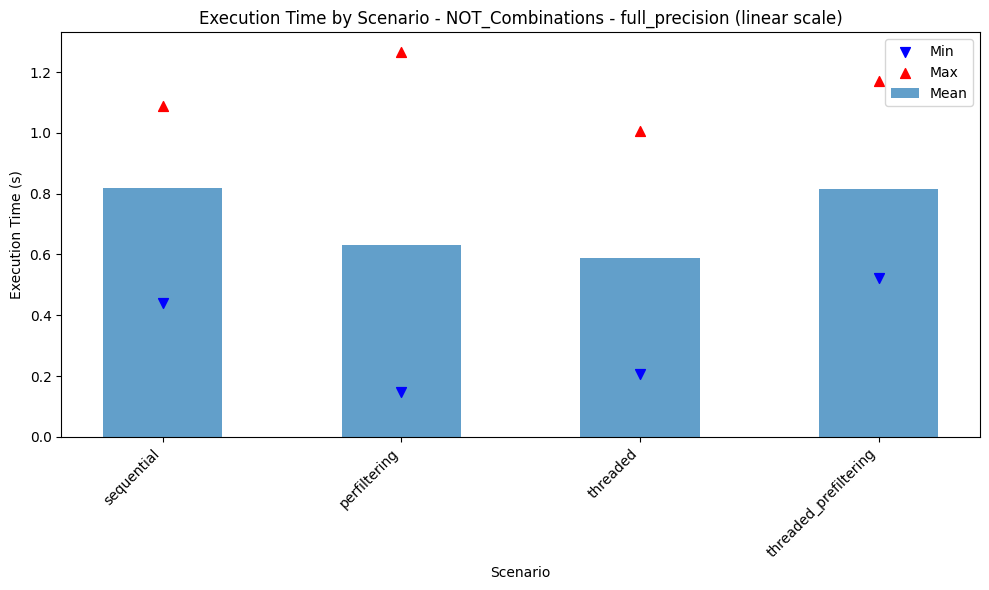

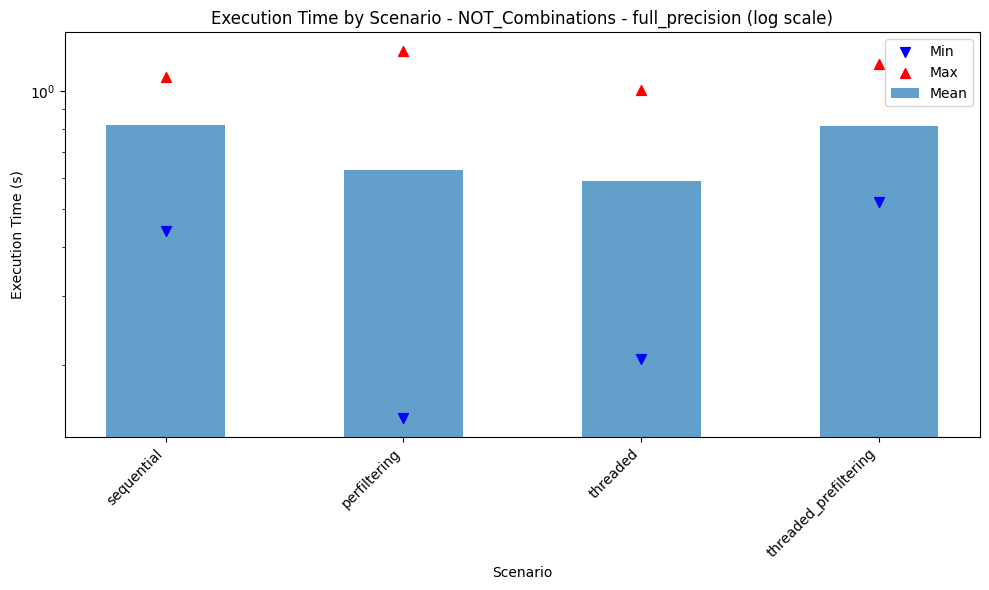

In [12]:
import numpy as np
# Compare execution time (y-axis min, max, mean) against scenario (x-axis) for one plot per fainder mode per category
categories = df_latest["category"].unique()
fainder_modes = ["full_precision"]
for category in categories:
    df_category = df_latest[df_latest["category"] == category]

    for fainder_mode in fainder_modes:
        df_fainder_mode = df_category[df_category["fainder_mode"] == fainder_mode]
        
        # Create two figures - one with linear scale, one with log scale
        for scale_type in ["linear", "log"]:
            plt.figure(figsize=(10, 6))
            plt.title(
                f"Execution Time by Scenario - {category} - {fainder_mode} ({scale_type} scale)"
            )
            plt.xlabel("Scenario")
            plt.ylabel("Execution Time (s)")
            
            # Set log scale if needed
            if scale_type == "log":
                plt.yscale('log')

            # Group by scenario
            grouped_data = df_fainder_mode.groupby(["scenario"])

            # Get unique scenarios
            scenarios = df_fainder_mode["scenario"].unique()
            
            # Set up positions for bars
            x_positions = np.arange(len(scenarios))
            
            # Prepare labels
            labels = scenarios

            # Collect data for plotting
            min_times = []
            max_times = []
            mean_times = []

            for scenario, group in grouped_data:
                execution_times = group["execution_time"]

                # Calculate statistics
                min_times.append(execution_times.min())
                max_times.append(execution_times.max())
                mean_times.append(execution_times.mean())

            # Create bars for mean values
            plt.bar(x_positions, mean_times, width=0.5, alpha=0.7, label="Mean")

            # Add markers for min and max
            plt.scatter(x_positions, min_times, marker="v", color="blue", s=50, label="Min")
            plt.scatter(x_positions, max_times, marker="^", color="red", s=50, label="Max")

            # Set the x-tick labels to scenario names
            plt.xticks(x_positions, labels, rotation=45, ha="right")

            plt.legend()
            plt.tight_layout()
            if scale_type == "linear":
                plt.savefig(
                    f"figures/analysis/{category}_{fainder_mode}_by_scenario.png"
                )
            else:
                plt.savefig(
                    f"figures/analysis/{category}_{fainder_mode}_by_scenario_{scale_type}.png"
                )
